<h1><center> I. Preparation </center></h1>

In [1]:
import pandas as pd
import numpy as np
from pmdarima.arima import auto_arima
from pmdarima.arima import decompose
from pmdarima.model_selection import cross_val_score
from pmdarima.model_selection import RollingForecastCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from itertools import product
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics import tsaplots
import matplotlib.collections
import matplotlib.gridspec as gridspec

sns.set_theme(rc={'grid.linewidth': 0.5,
                  'axes.linewidth': 0.75, 'axes.facecolor': '#ECECEC', 
                  'axes.labelcolor': 'black',
                  'figure.facecolor': '#f7f7f7',
                  'xtick.color': 'black', 'ytick.color': 'black'})

<p><div style = "text-align: justify; font-size: 14px">Importing data and creating basic variables indicating months and years:</div></p>

In [2]:
Data = pd.read_excel('./0_Data/economics_data.xlsx', sheet_name = 'Sheet1')

train_idx, test_idx = (Data['Date'] < '2015-07-01'), (Data['Date'] >= '2015-07-01')
train, test = Data.loc[train_idx].copy(), Data.loc[test_idx].copy()

# Calendar variables

train['Month'] = pd.DatetimeIndex(train['Date']).month
train['Year'] = pd.DatetimeIndex(train['Date']).year
test['Month'] = pd.DatetimeIndex(test['Date']).month
test['Year'] = pd.DatetimeIndex(test['Date']).year

train.head()

Date     Y  Month  Year
0 1990-01-01  6370      1  1990
1 1990-02-01  6430      2  1990
2 1990-03-01  6520      3  1990
3 1990-04-01  6580      4  1990
4 1990-05-01  6620      5  1990

<h1><center> II. Quick EDA </center></h1>

## 1. First glimps <a class="anchor" id = "II_1"></a>

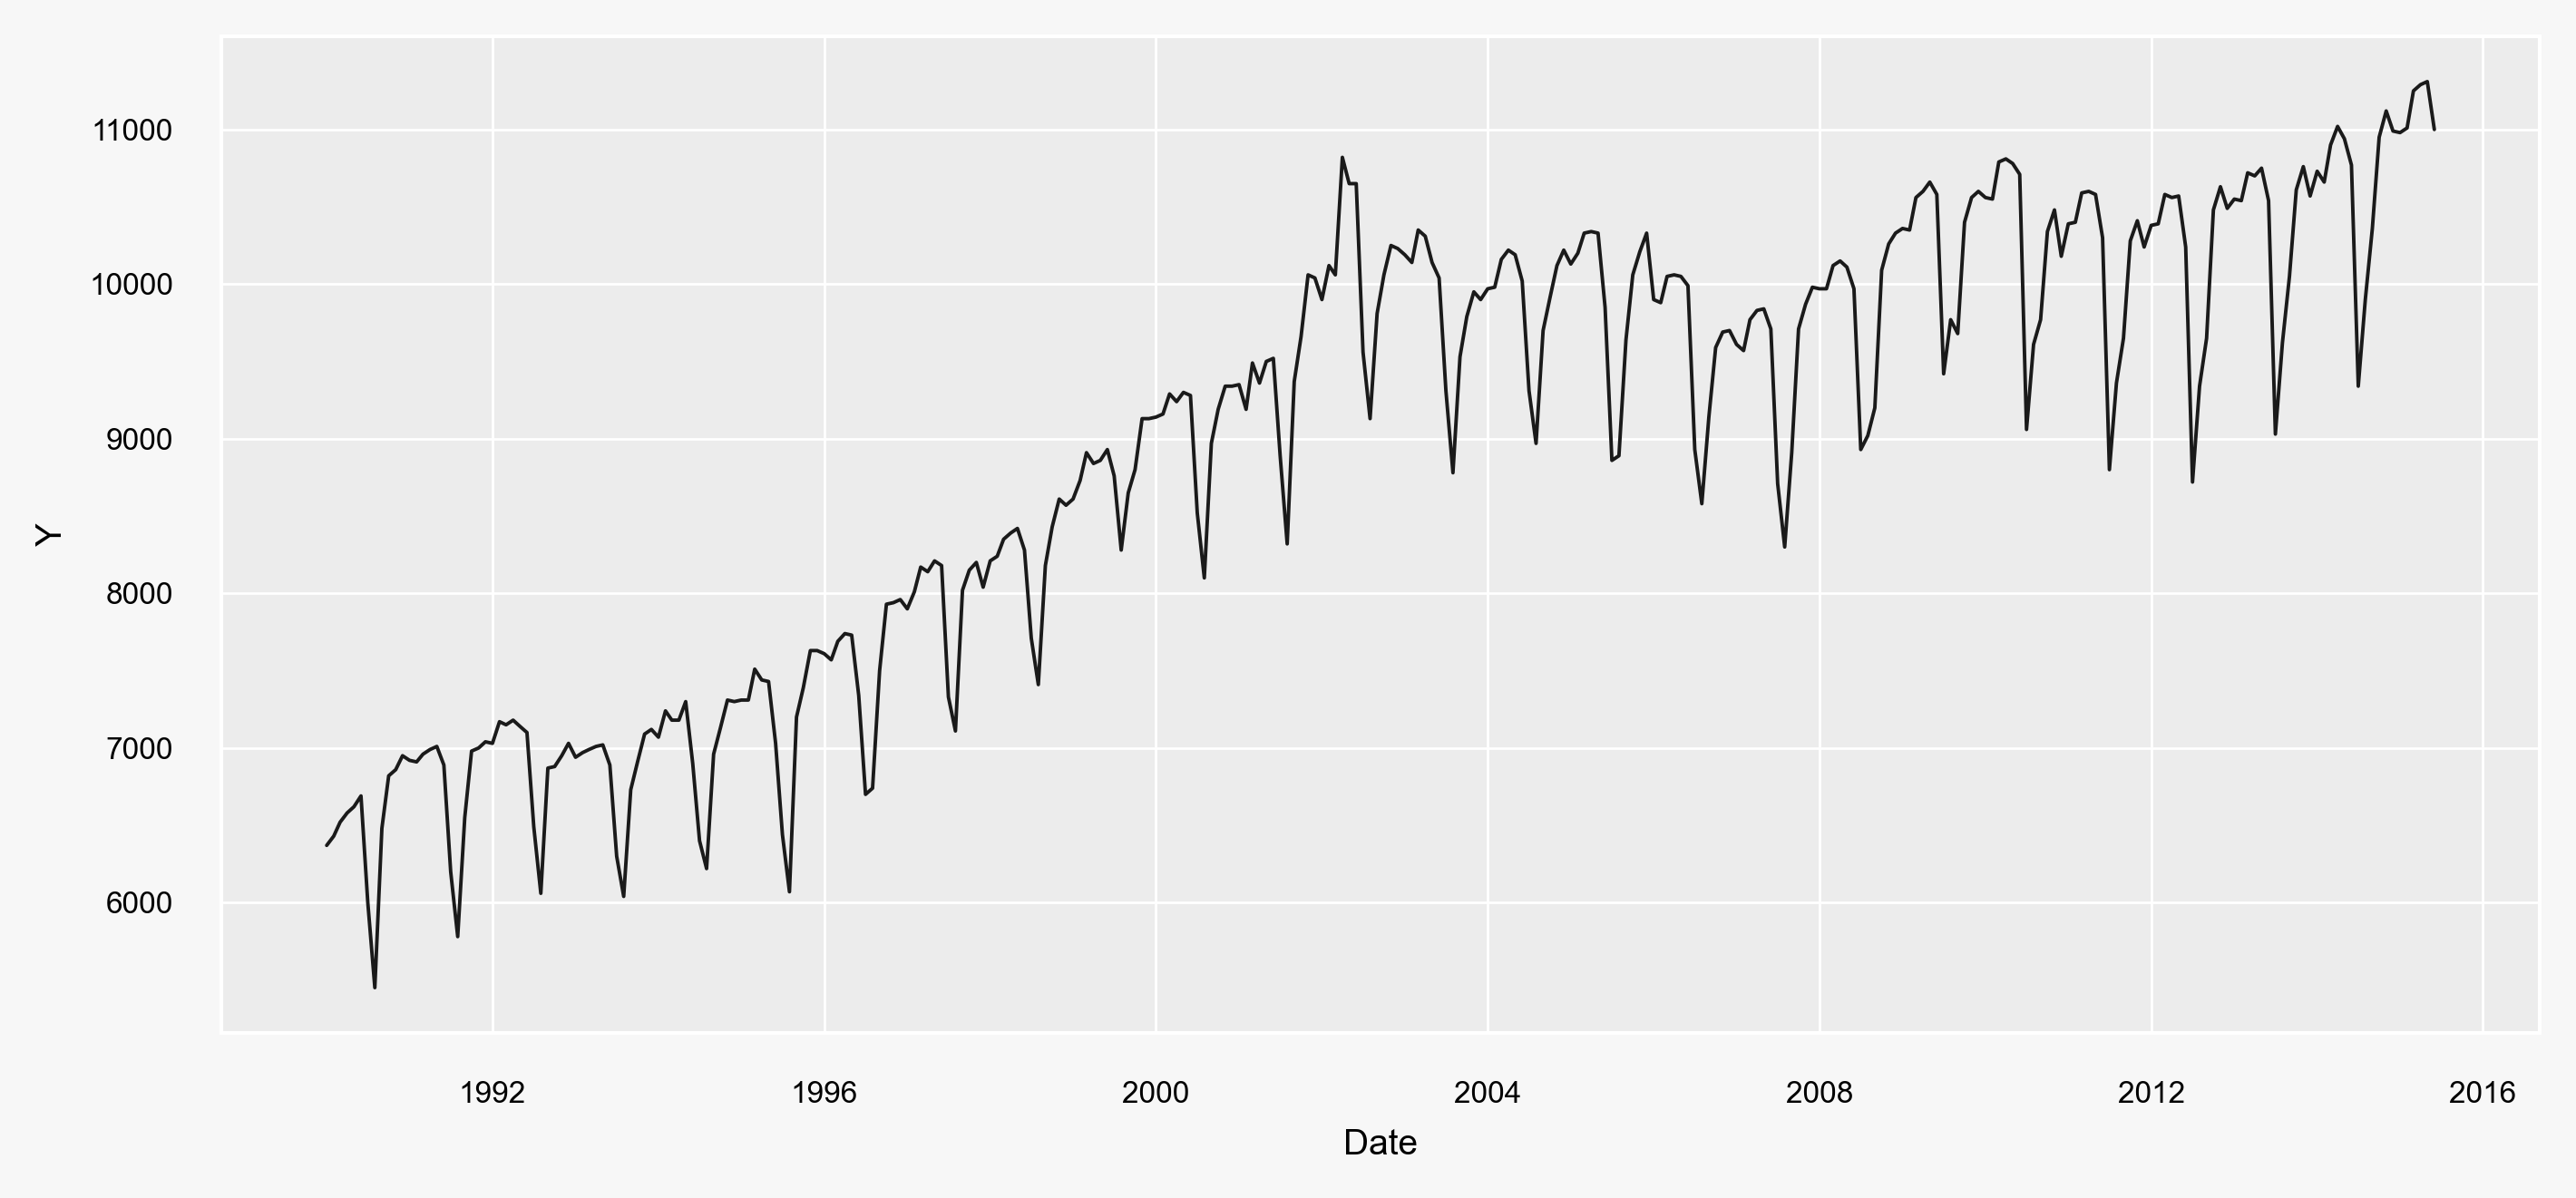

In [28]:
with plt.rc_context(rc={'figure.dpi': 400, 'axes.labelsize': 7, 
                        'xtick.labelsize': 6, 'ytick.labelsize': 6}):

    fig, ax = plt.subplots(2, 1, figsize=(7, 6))
    
    sns.lineplot(ax=ax[0], x=train['Date'], y=train['Y'],
                 color='k', lw=0.7)
        
    ax[1].set_visible(False)

    plt.tight_layout(pad=0.3)
    plt.show()

## 2. Time series decomposition <a class="anchor" id = "II_2"></a>

<p><div style = "text-align: justify; font-size: 14px">One of the best options to explore your data is to use time-series decomposition. Normally, $STL$ handles most of time-series data just fine. Nevertheless, it cannot handle multiplicative seasonality, at least not directly. You need to use a power transformation and then back-transform your components, which does not always work perfectly.</div></p>

In [29]:
stl_add = STL(train['Y'], period=12, seasonal=13, robust=True).fit()

T, S, R = stl_add.trend, stl_add.seasonal, stl_add.resid

stl_add_results = pd.DataFrame(zip(train['Y'], T, S, R),
                               columns=('Y', 'Trend', 'Seasonal', 'Residuals'))

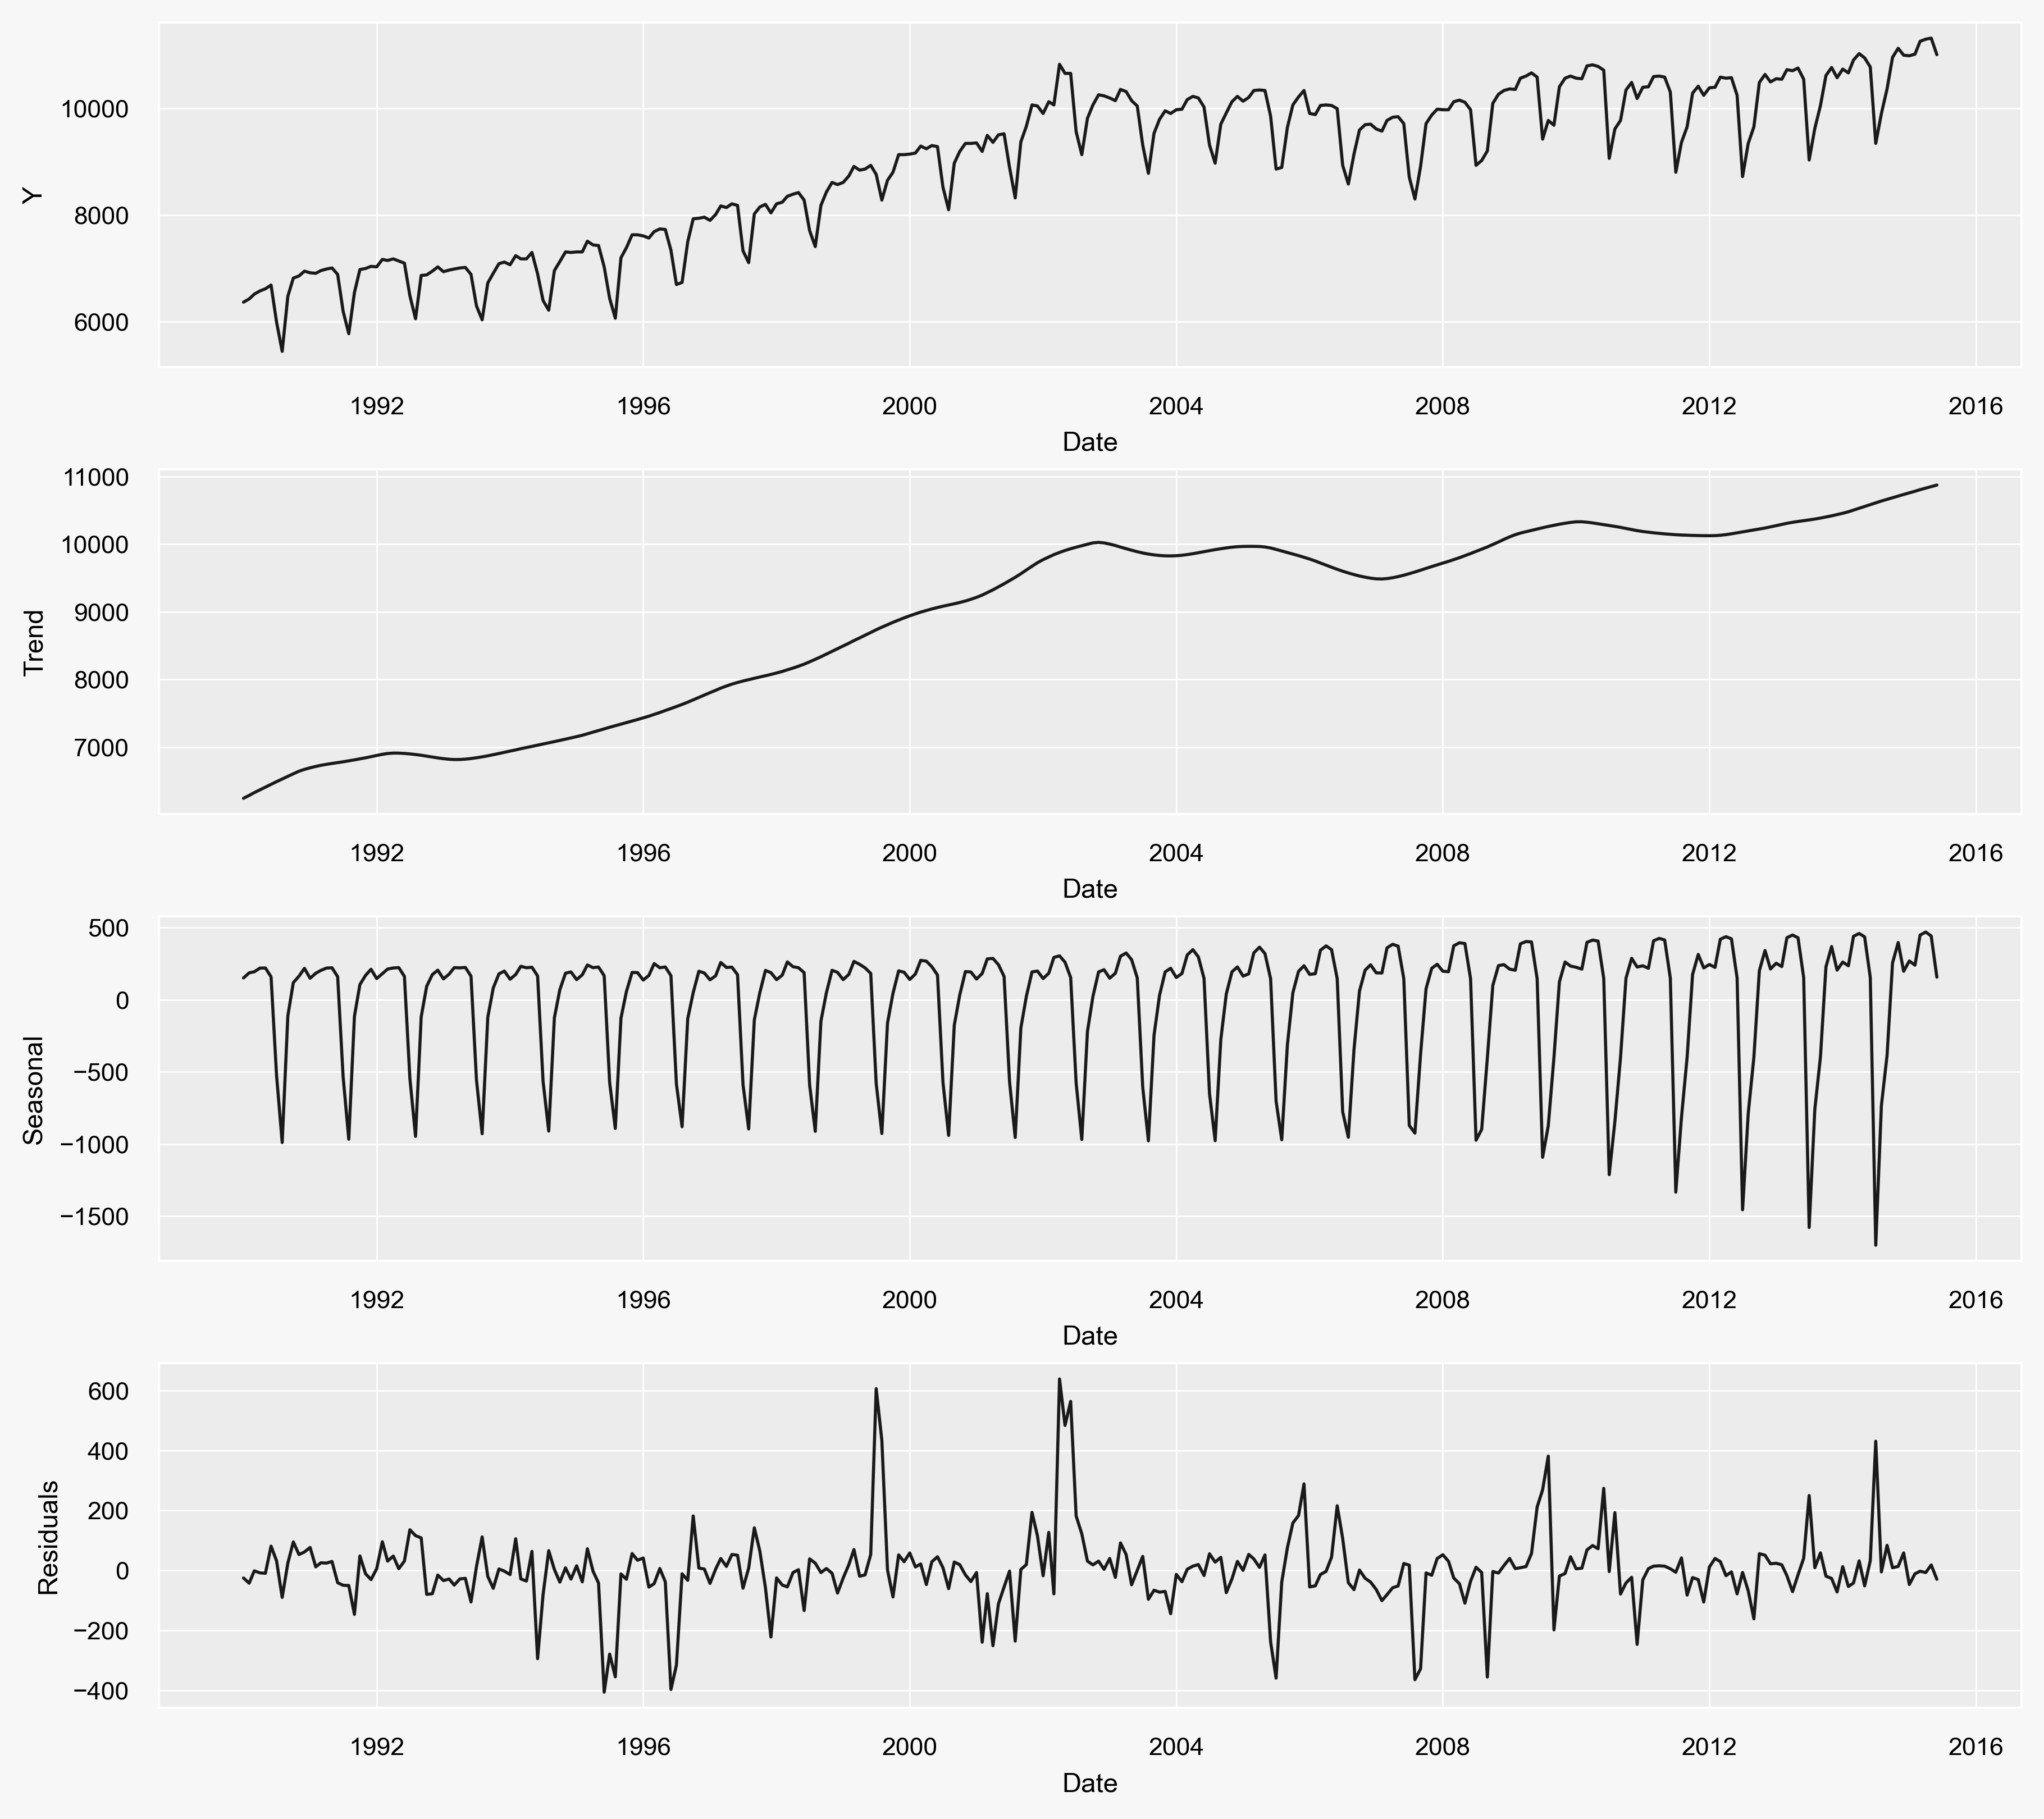

In [30]:
with plt.rc_context(rc={'figure.dpi': 400, 'axes.labelsize': 8.5, 
                        'xtick.labelsize': 8, 'ytick.labelsize': 8,
                        'legend.fontsize': 8}):

    fig, ax = plt.subplots(4, 1, figsize=(9, 8))

    for idx, (col, axes) in enumerate(zip(stl_add_results.columns, ax.flatten())):
    
        sns.lineplot(ax=axes, x=train['Date'], y=stl_add_results[col],
                     color='k', lw=1)

    plt.tight_layout(pad=0.3)
    plt.show()

<p><div style = "text-align: justify; font-size: 14px"><b>Summary</b>:</div></p>

* <div style = "font-size: 14px">We can clearly observe that the seasonal component was not additive;</div>
* <div style = "font-size: 14px">Both the trend-cycle and the seasonal componen contributed a lot to the overall variance.</div>

<p><div style = "text-align: justify; font-size: 14px">Since in this case time-series decomposition was used so as to quickly explore data, the decision was made not to spend extra time trying to find an appropriate Box-Cox transformation. Instead, the classic method that allows for the multiplicative seasonal component was applied:</div></p>

In [31]:
decomp_m = seasonal_decompose(np.array(train['Y']), period = 12, model = 'multiplicative')

T, S, R = decomp_m.trend, decomp_m.seasonal, decomp_m.resid

decomp_m_results = pd.DataFrame(zip(train['Y'], T, S, R),
                                columns = ('Y', 'Trend', 'Seasonal', 'Residuals'))

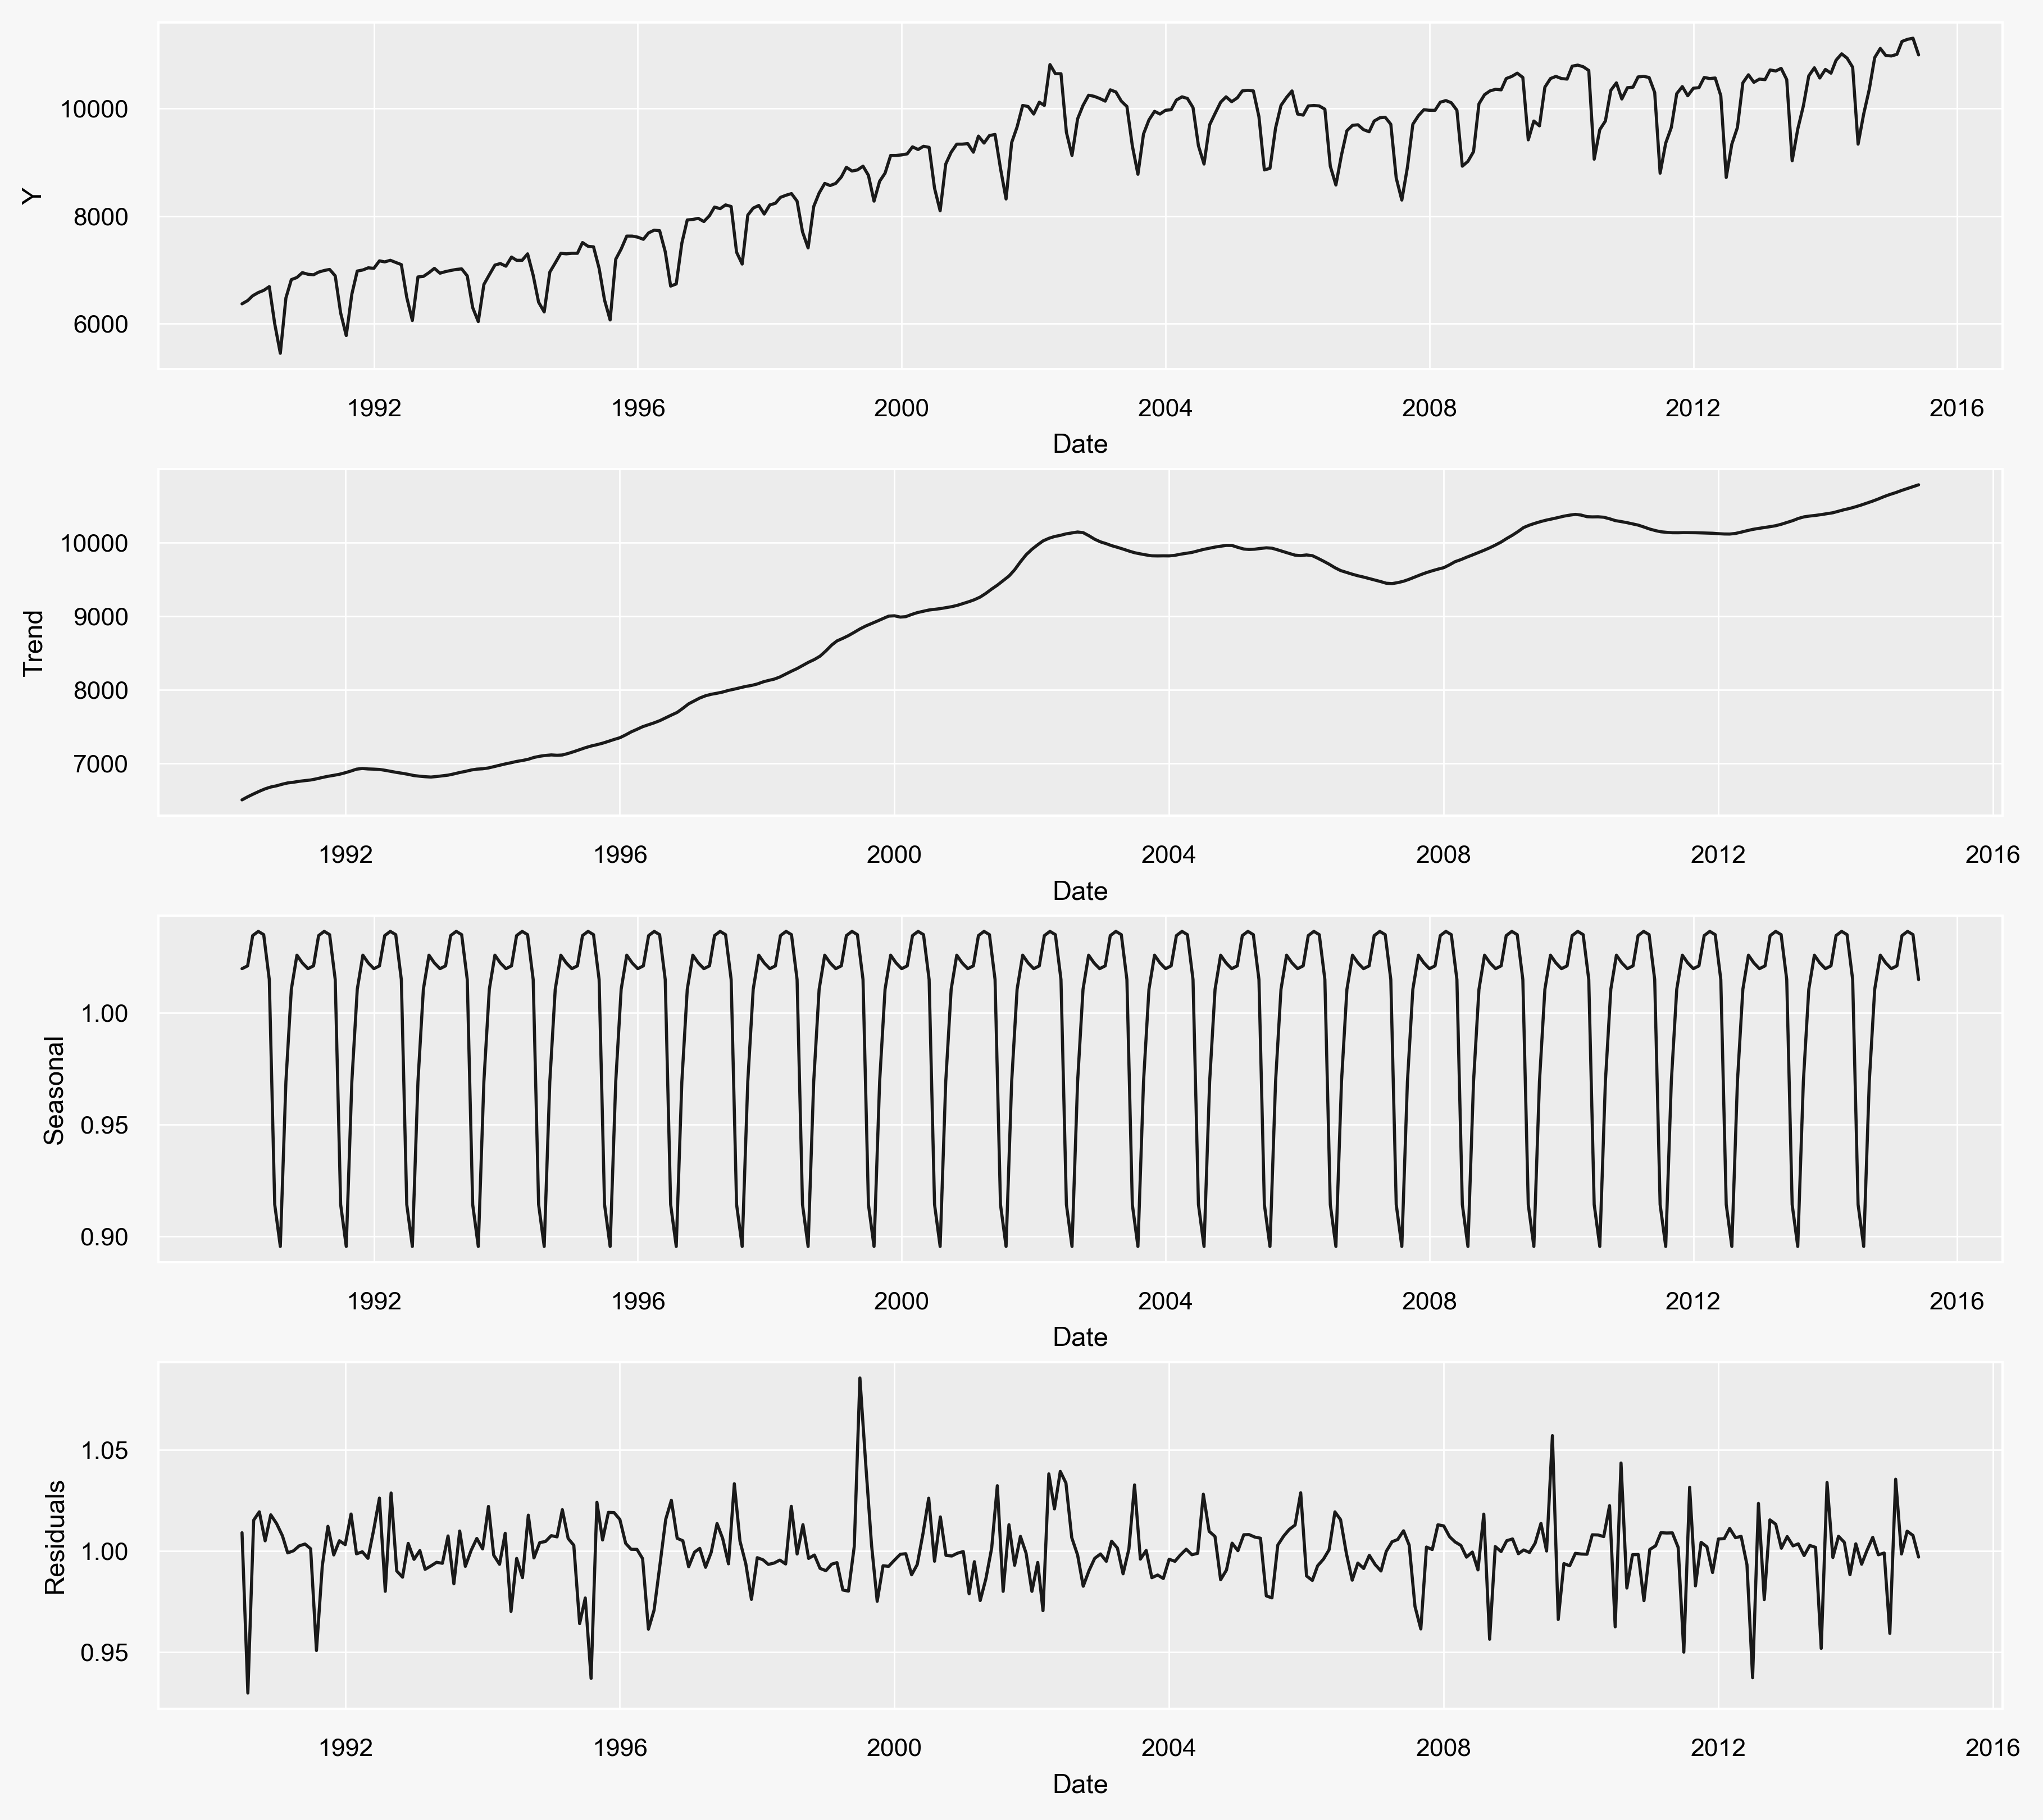

In [32]:
with plt.rc_context(rc={'figure.dpi': 400, 'axes.labelsize': 8.5, 
                        'xtick.labelsize': 8, 'ytick.labelsize': 8,
                        'legend.fontsize': 8}):

    fig, ax = plt.subplots(4, 1, figsize=(9, 8))

    for idx, (col, axes) in enumerate(zip(decomp_m_results.columns, ax.flatten())):
    
        sns.lineplot(ax=axes, x=train['Date'], y=decomp_m_results[col],
                     color='k', lw=1)

    plt.tight_layout(pad=0.3)
    plt.show()

## 3. Seasonal plots <a class="anchor" id = "II_3"></a>

<p><div style = "text-align: justify; font-size: 14px">Creating seasonal plots might also be quite helpful in detecting some unusual behaviours:</div></p>

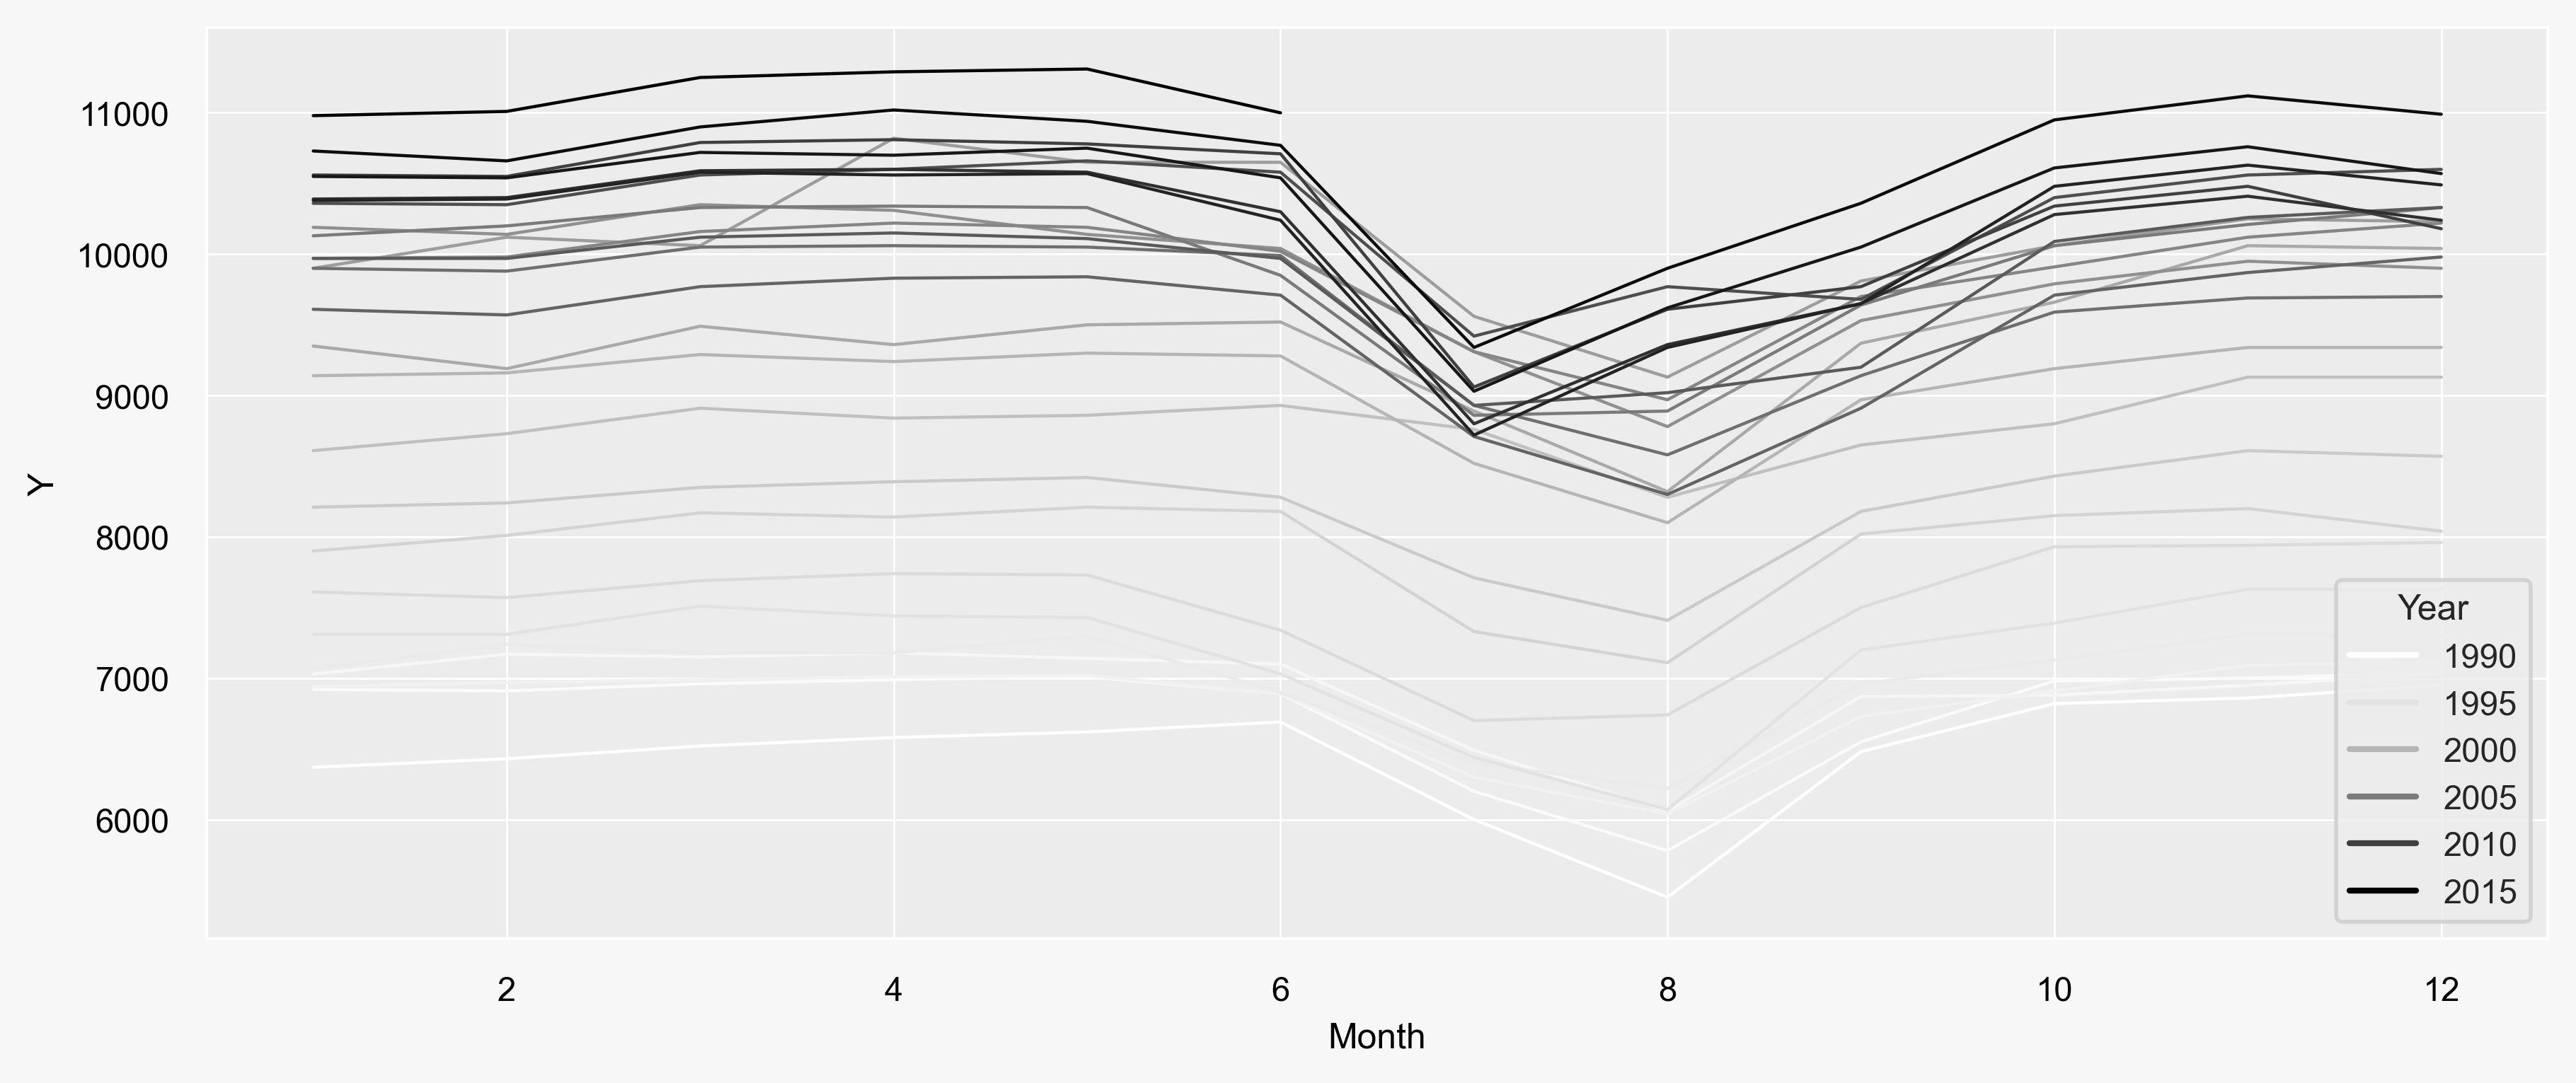

In [33]:
with plt.rc_context(rc={'figure.dpi': 400, 'axes.labelsize': 9, 
                        'xtick.labelsize': 8.5, 'ytick.labelsize': 8.5,
                        'legend.fontsize': 8.5, 'legend.title_fontsize': 9}):

    fig, ax = plt.subplots(2, 1, figsize=(9, 7))
    
    sns.lineplot(ax=ax[0], x=train['Month'], y=train['Y'], 
                 hue=train['Year'], palette='Greys', linewidth=0.8)  # legend='full'
    
    ax[1].set_visible(False)
    
    plt.tight_layout(pad=0.3)
    plt.show()

<p><div style = "text-align: justify; font-size: 14px">It can be seen that recent years had a different pattern: July was lower than usual while August was higher. Such changes can be incorporated in a model via dummy variables. But first we need to determine when exactly this change occurred:</div></p>

In [34]:
Proportions = round(train['Y'] / train.groupby(['Year'])['Y'].transform(np.sum), 3)
Proportions = pd.concat([train['Year'], train['Month'], Proportions], axis = 1)

Proportions_7_8 = Proportions.loc[(Proportions['Month'] == 7) | (Proportions['Month'] == 8)]

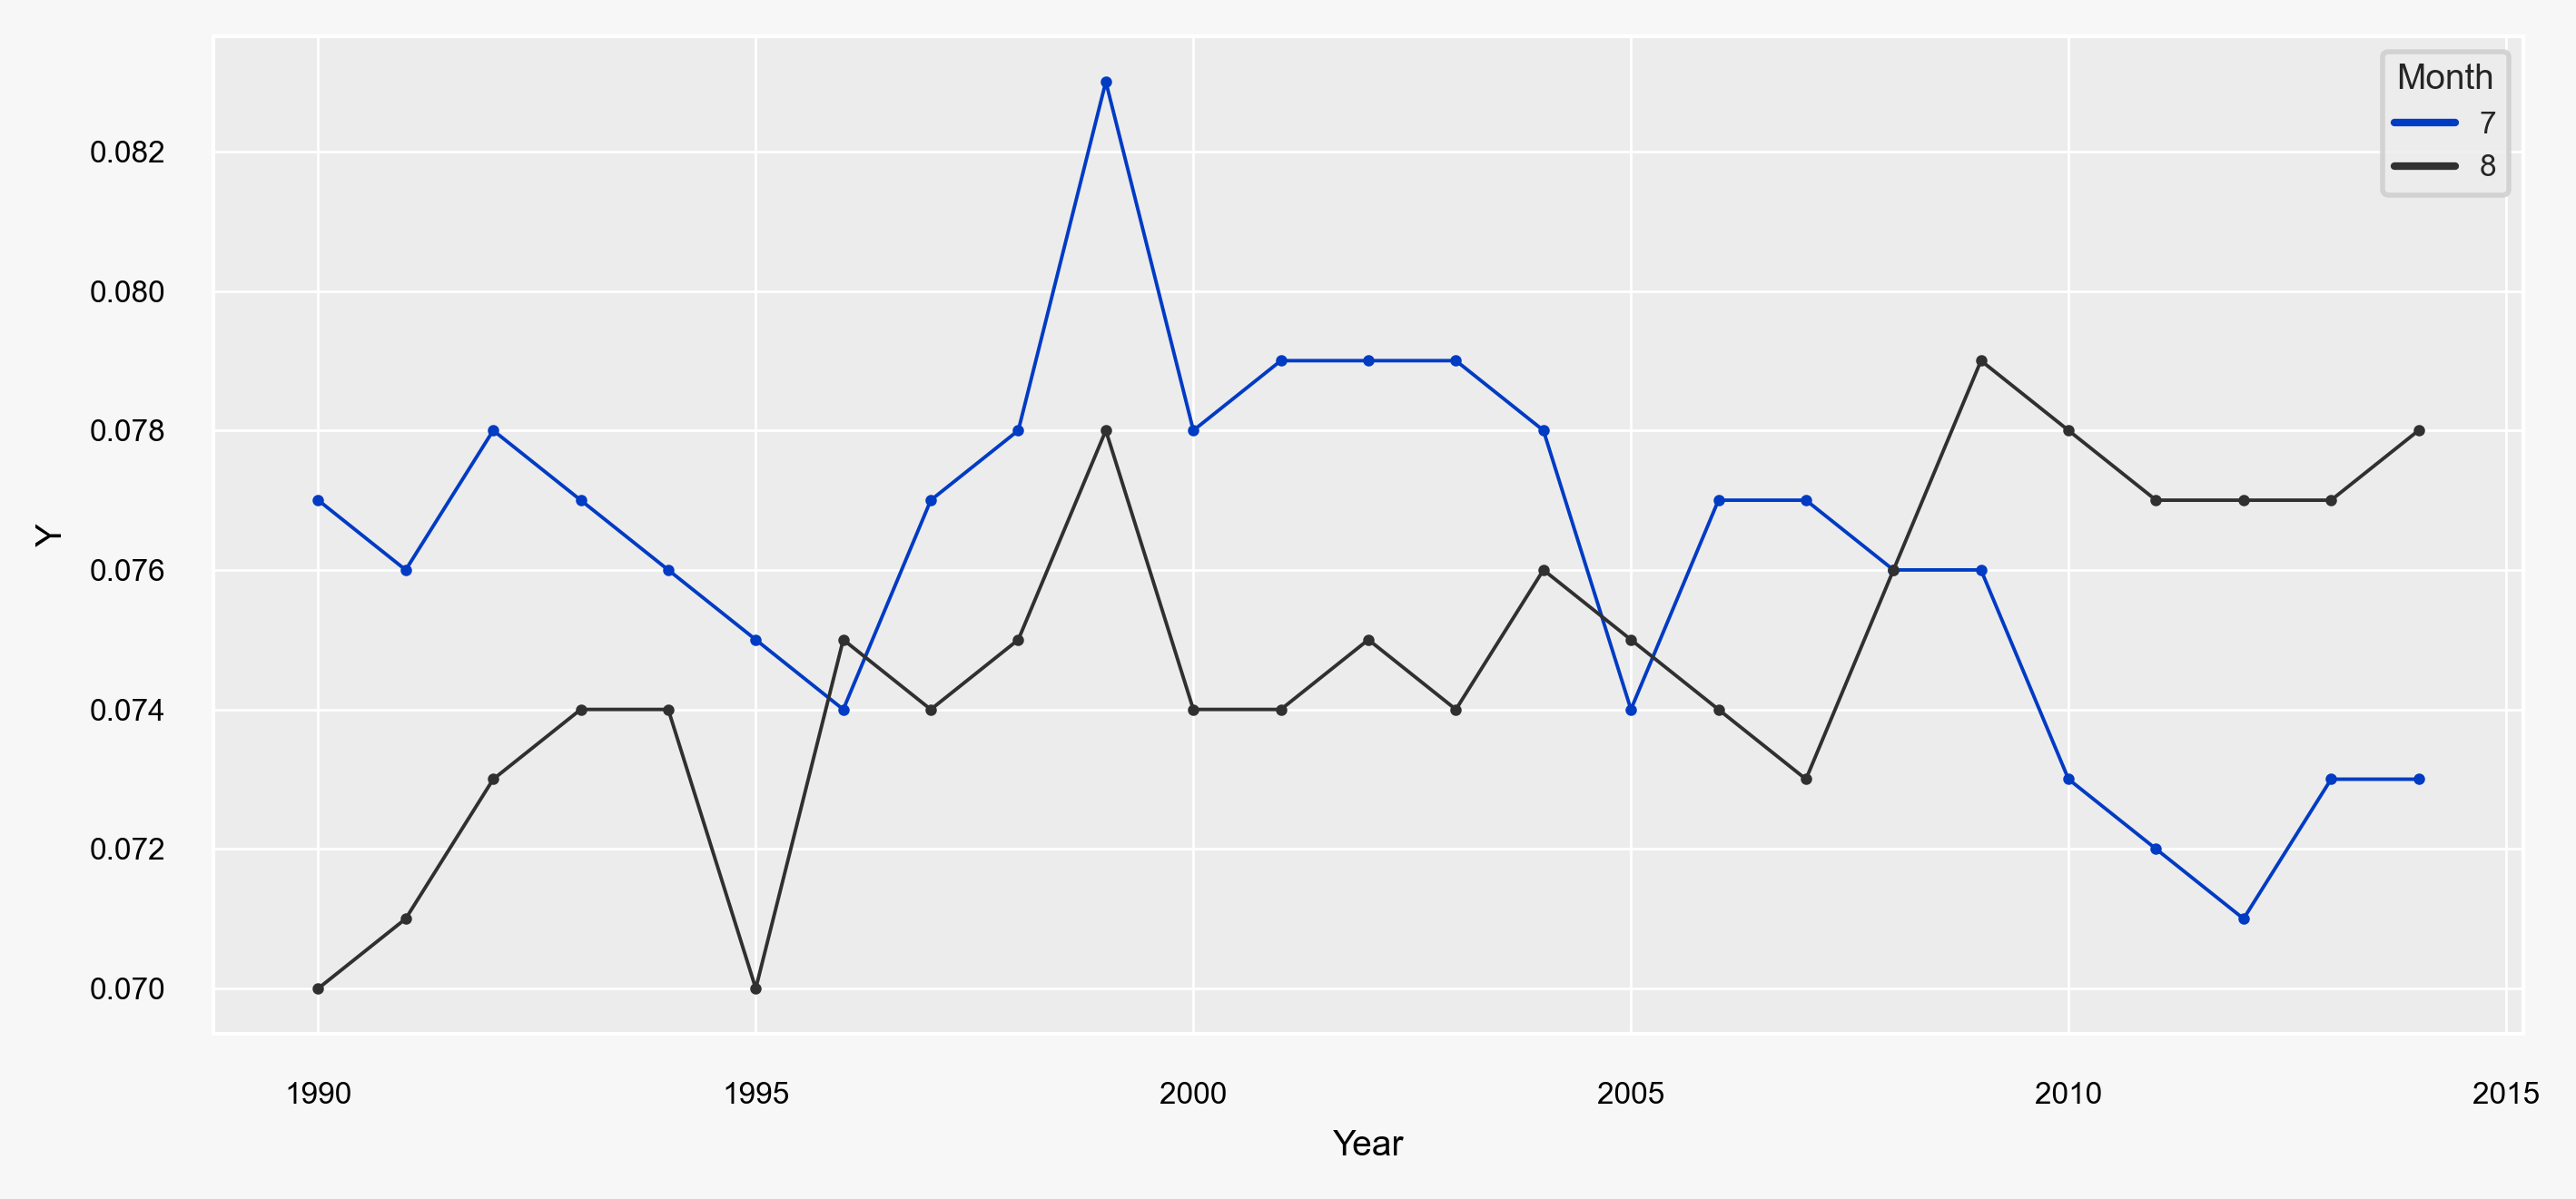

In [35]:
with plt.rc_context(rc={'figure.dpi': 400, 'axes.labelsize': 7, 
                        'xtick.labelsize': 6, 'ytick.labelsize': 6, 
                        'legend.fontsize': 6, 'legend.title_fontsize': 7}):

    fig, ax = plt.subplots(2, 1, figsize=(7, 6))
    
    sns.lineplot(ax=ax[0], x=Proportions_7_8['Year'], y=Proportions_7_8['Y'],
                 hue=Proportions_7_8['Month'], palette=['#003bc4', '#303030'],
                 lw=0.7, marker='o', markersize=1.5, markeredgecolor=None)
        
    ax[1].set_visible(False)

    plt.tight_layout(pad=0.3)
    plt.show()

<p><div style = "text-align: justify; font-size: 14px">After 2009, a previously stable pattern – high Julys and low Augusts – changed.</div></p>

<h1><center> III. Regression with ARIMA errors </center></h1>

## 1. Feature engineering <a class="anchor" id = "III_1"></a>

### 1.1 Mean encoding <a class="anchor" id = "III_1_1"></a>

<p><div style = "text-align: justify; font-size: 14px">Mean encoding can be quite beneficial not only for dealing with high-cardinality predictors, but also for helping your model recognize vital trends in your data without overfitting. This function uses <code>TimeSeriesSplit</code> instead of usual <code>KFold</code> to properly split time series data:</div></p>

In [36]:
def mean_encode(train, test, Xs, Y, alpha=0, n_splits=5, test_size=None):
    enc_train_df = []
    enc_test_df = []
    glob_mean = train[Y].mean()
    
    for col in Xs:
        group_obs = train.groupby(col)[Y].count()
        group_mean = train.groupby(col)[Y].mean()
        group_mean_adj = (group_mean * group_obs + glob_mean * alpha) / (group_obs + alpha)
        enc_test = test[col].map(group_mean_adj)
        
        tscv = TimeSeriesSplit(n_splits=n_splits, gap=0, test_size=test_size, 
                               max_train_size=None).split(train[Y])
        
        mean_values = []
        
        for idx, (tr_idx, val_idx) in enumerate(tscv):
            df_train, df_val = train.iloc[tr_idx], train.iloc[val_idx]
    
            group_obs = df_train.groupby(col)[Y].count()
            group_mean = df_train.groupby(col)[Y].mean()
            group_mean_adj = (group_mean * group_obs + glob_mean * alpha) / (group_obs + alpha)
            
            if idx == 0:
                mean_values.append(df_train[col].map(group_mean_adj))
                mean_values.append(df_val[col].map(group_mean_adj))
        
            else: 
                mean_values.append(df_val[col].map(group_mean_adj))
                
            enc_train = pd.concat(mean_values, axis=0)
            enc_train = enc_train.fillna(glob_mean)  
            
        enc_train_df.append(pd.DataFrame({f'mean_{col}': enc_train}))
        enc_test_df.append(pd.DataFrame({f'mean_{col}': enc_test}))
    enc_Xs_train = pd.concat(enc_train_df, axis=1)
    enc_Xs_test = pd.concat(enc_test_df, axis=1)
            
    return enc_Xs_train, enc_Xs_test

<p><div style = "text-align: justify; font-size: 14px"> To use this function, pass data sets (<code>train</code> and <code>test</code>), predictors you want to encode (<code>Xs</code>), your dependent variable (<code>Y</code>), the regularization parameter (<code>alpha</code>) and the number of splits your data will be divided into (<code>n_splits</code>). Again, both <code>alpha</code> and <code>n_splits</code> should be determined based on the lowest CV scores. Let's consider a brief example:</div></p>

In [37]:
m_encs = []

for a in [1, 2, 3]:
    mean_enc_example = mean_encode(train=train, test=test, Xs=['Month'], 
                                   Y='Y', alpha=a, n_splits=5, test_size=None)
    
    m_encs.append(mean_enc_example[0])

mean_enc_train = pd.DataFrame(np.reshape(m_encs, newshape = (3, 306)), 
                              index = [f'alpha = {a}, n_splits = 5' for a in [1, 2, 3]]).T

mean_enc_train['Date'] = train['Date']
mean_enc_train['Y'] = train['Y']

mean_enc_train = pd.melt(mean_enc_train, id_vars=['Date'],
                         value_vars=['alpha = 1, n_splits = 5', 'alpha = 2, n_splits = 5', 
                                     'alpha = 3, n_splits = 5', 'Y'])

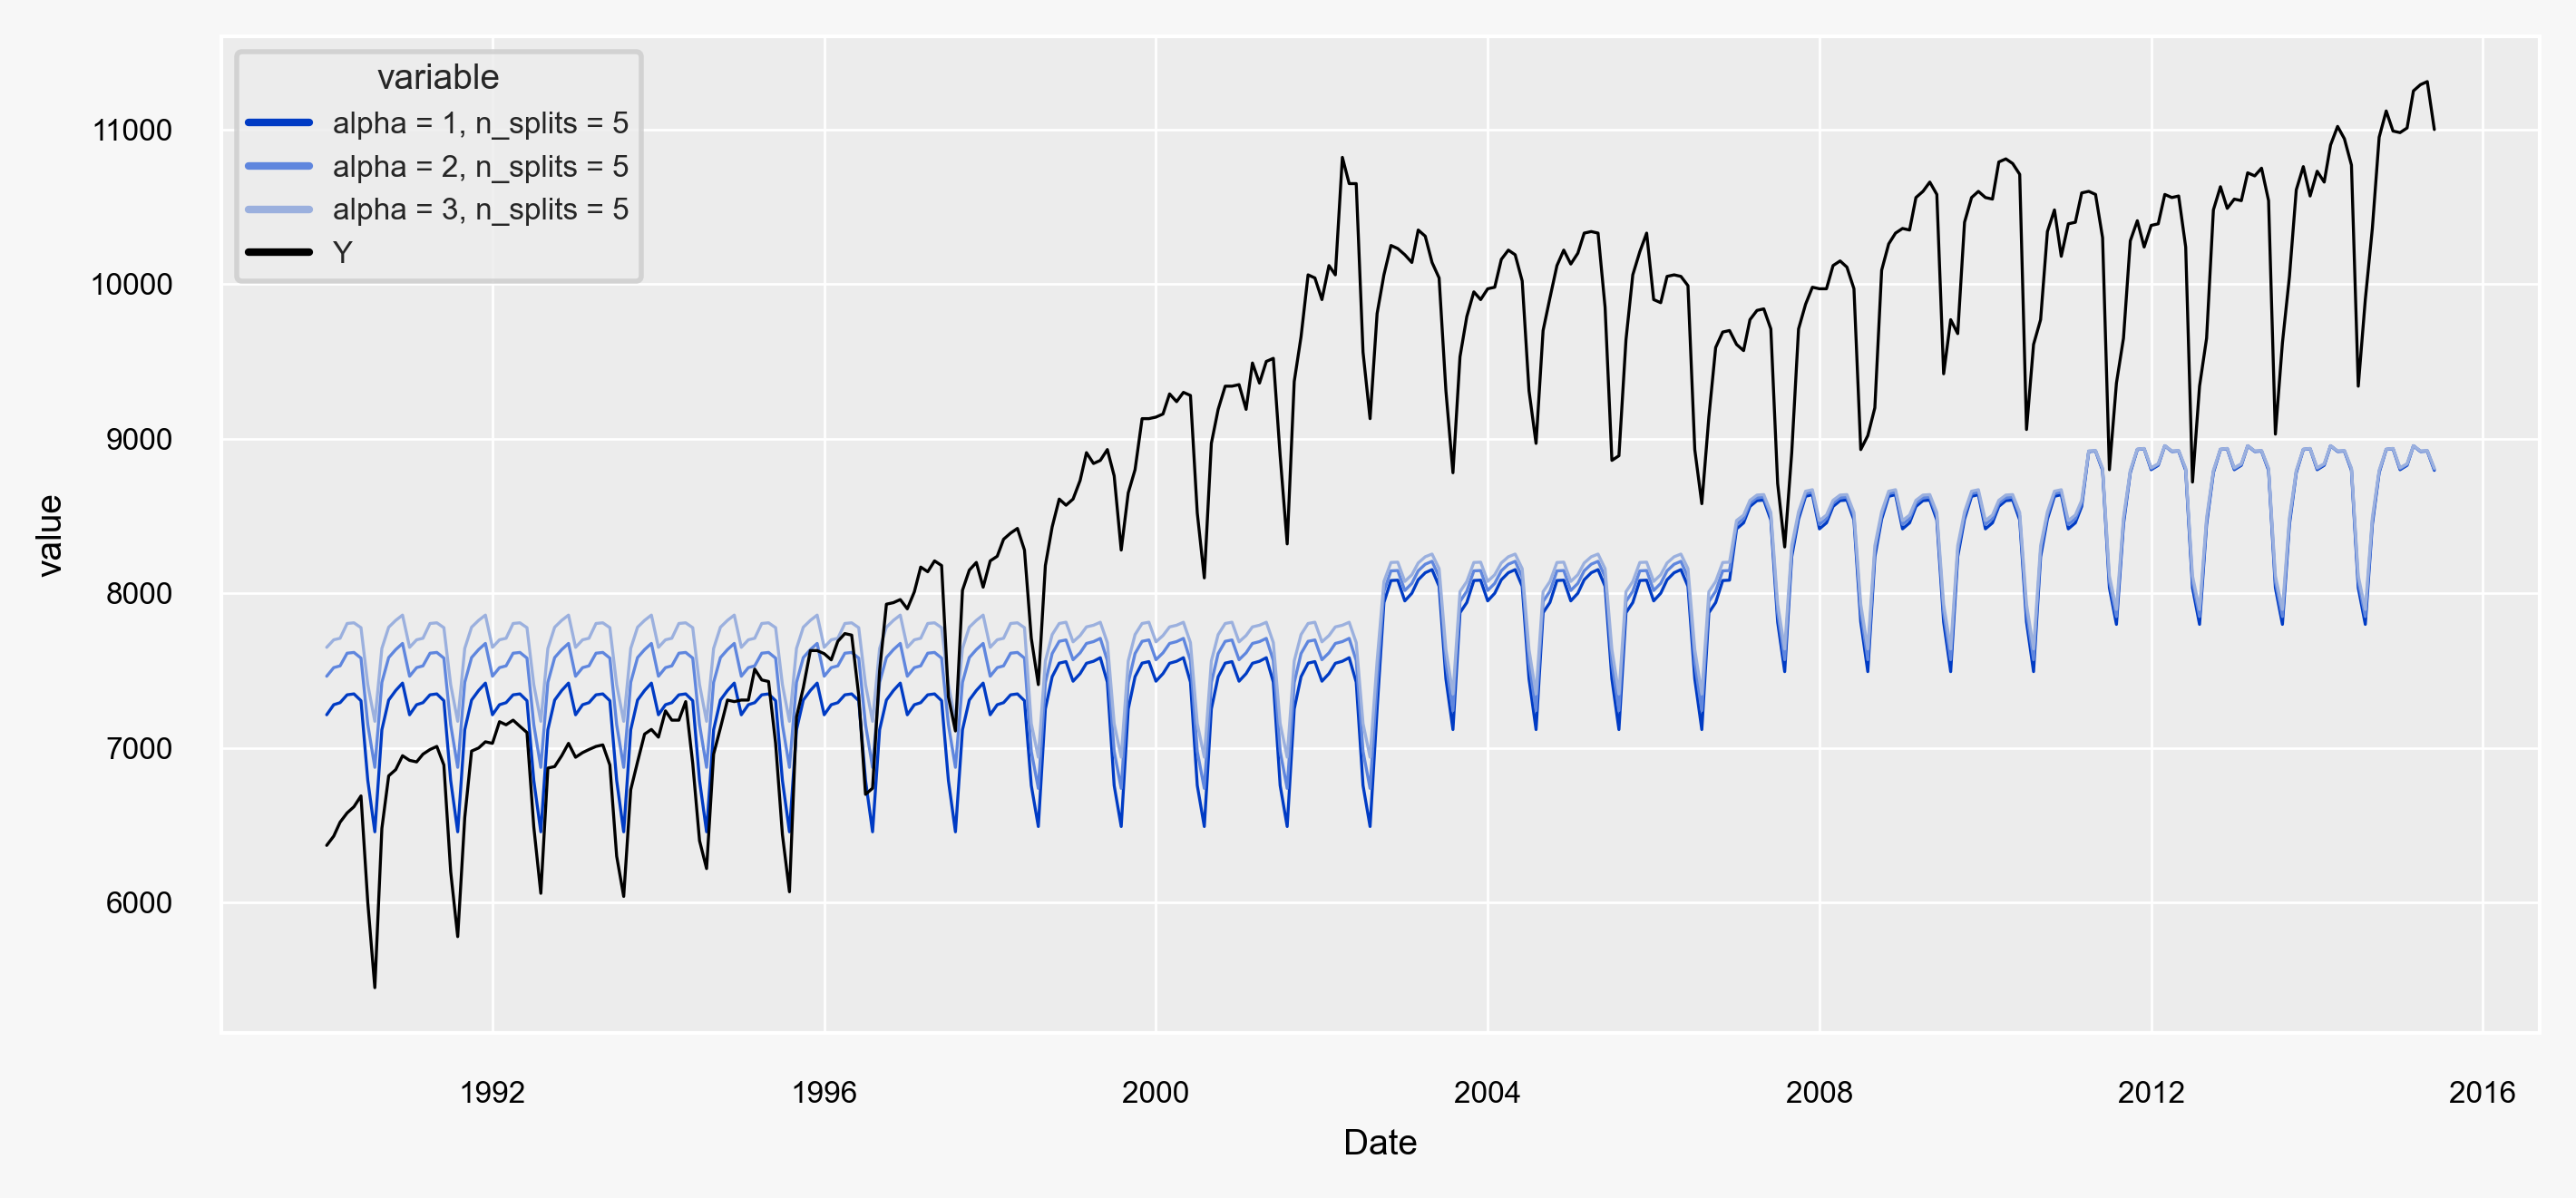

In [38]:
with plt.rc_context(rc = {'figure.dpi': 400, 'axes.labelsize': 7, 
                          'xtick.labelsize': 6, 'ytick.labelsize': 6,
                          'legend.fontsize': 6, 'legend.title_fontsize': 7}):

    fig, ax = plt.subplots(2, 1, figsize = (7, 6))
    
    sns.lineplot(ax = ax[0], x = mean_enc_train['Date'], y = mean_enc_train['value'],
                 hue = mean_enc_train['variable'],
                 palette = ['#003bc4', '#5f86de', '#9bb0de', '#000000'], lw = 0.6)
        
    ax[1].set_visible(False)

    plt.tight_layout(pad = 0.3)
    plt.show()

### 1.2 Flag variables <a class="anchor" id = "III_1_2"></a>

<p><div style = "text-align: justify; font-size: 14px">There are situations when you want to indicate outliers, one-of-a-kind events, trend changes etc. To do so, you can create flag variables that consist of 1s when something happened and 0s otherwise. Following that, you need to decide whether this unusual pattern will reoccur or not, assigning 1s or 0s to the variable in your test set. As had been already discussed, at least 2 phenomena needed to be indicated: </div></p>

In [39]:
def Flag(Month, Year):
    if (Month == 7) & (Year >= 2010): 
        return 1
    else: 
        return 0
    
Flag_0_tr = pd.DataFrame({'Flag_0': [Flag(x, y) for x, y in zip(train['Month'], train['Year'])]})
Flag_0_te = pd.DataFrame({'Flag_0': [Flag(x, y) for x, y in zip(test['Month'], test['Year'])]}).set_index(test.index)

def Flag(Month, Year):
    if (Month == 8) & (Year >= 2010): 
        return 1
    else: 
        return 0
    
Flag_1_tr = pd.DataFrame({'Flag_1': [Flag(x, y) for x, y in zip(train['Month'], train['Year'])]})
Flag_1_te = pd.DataFrame({'Flag_1': [Flag(x, y) for x, y in zip(test['Month'], test['Year'])]}).set_index(test.index)

Flags_tr = pd.concat([Flag_0_tr, Flag_1_tr], axis=1)
Flags_te = pd.concat([Flag_0_te, Flag_1_te], axis=1)

### 1.3 Grid search (mean encoding parameters) <a class="anchor" id = "III_1_3"></a>

<p><div style = "text-align: justify; font-size: 14px">Guessing the regularization parameter (<code>alpha</code>) and the number of splits (<code>n_splits</code>) is probably not the wisest idea. Thus, you can build a simple loop to calculate $AIC$ and $RMSE$ to find the possible best combination:</div></p>

In [41]:
alpha, n_splits = [1, 2, 3], [7, 10]
opt_params = list(product(alpha, n_splits))
Xs = ['Month']
X_mean_enc = []

for a, n_spl in opt_params:
    m_enc = mean_encode(train=train, test=test, Xs=Xs, Y='Y', 
                        alpha=a, n_splits=n_spl, test_size=None)
    
    X_mean_enc.append(pd.concat([m_enc[0], Flags_tr], axis=1))

Y_train = train['Y']

In [42]:
CV = RollingForecastCV(h=12, step=3, initial=None)

Baseline_rmse = []
Baseline_aic = []

for df in X_mean_enc:
    model_baseline = auto_arima(y=Y_train, X=df, start_p=0, d=None, start_q=0, 
                                max_p=4, max_d=2, max_q=4, 
                                start_P=0, D=None, start_Q=0, max_P=3, max_D=1, max_Q=3, max_order=8,
                                start_params=None,
                                stepwise=True, maxiter=15,
                                m=12, seasonal=True, stationary=False, 
                                information_criterion='aic', 
                                alpha=0.05, test='kpss', seasonal_test='ocsb',
                                with_intercept='auto', method='lbfgs',
                                suppress_warnings=True, error_action='ignore', trace=False)

    score = cross_val_score(model_baseline, y=Y_train, X=df, scoring='mean_squared_error',
                            cv=CV, verbose=0)
    
    Baseline_rmse.append(round((sum(score) / len(score))**(0.5), 2))
    Baseline_aic.append(round(model_baseline.aic(), 2))

In [43]:
Scores = pd.DataFrame({'AIC': Baseline_aic, 'RMSE': Baseline_rmse}, index = opt_params).reset_index()
Scores.sort_values(by = 'RMSE').head()

index      AIC    RMSE
5  (3, 10)  3963.12  303.81
3  (2, 10)  3960.52  305.16
1  (1, 10)  3960.96  307.70
4   (3, 7)  3995.05  318.39
2   (2, 7)  3989.20  334.57

<p><div style = "text-align: justify; font-size: 14px">Based on the $RMSE$ score, the optimal combination was <code>alpha = 3</code>, <code>n_splits = 10</code>. You can choose pretty much any metrics you want and even calculate the weighted average should you want to.</div></p>

## 2. Preparing train and test data <a class="anchor" id = "III_2"></a>

In [44]:
Xs_encoded = mean_encode(train=train, test=test, Xs=['Month'], Y='Y', 
                         alpha=3, n_splits=10, test_size=None)

M_enc_train, M_enc_test = Xs_encoded[0], Xs_encoded[1]

X_train = pd.concat([M_enc_train, Flags_tr], axis=1)
X_test = pd.concat([M_enc_test, Flags_te], axis=1)

Y_train, Y_test = train['Y'], test['Y']

## 3. Building a model (historical data only, no assumptions) <a class="anchor" id = "III_3"></a>

### 3.1 Model tuning <a class="anchor" id = "III_3_1"></a>

<p><div style = "text-align: justify; font-size: 14px">Using <code>auto_arima</code> allows you to search for the best possible model. There are several options: a grid search (<code>stepwise = False</code>), a random search (<code>stepwise = False</code> and <code>random = True</code>) and a stepwise search (<code>stepwise = True</code>):</div></p>

In [45]:
model_0 = auto_arima(y=Y_train, X=X_train, start_p=0, d=None, start_q=0, 
                     max_p=4, max_d=2, max_q=4, 
                     start_P=0, D=None, start_Q=0, max_P=3, max_D=1, max_Q=3, max_order=8,
                     start_params=None,
                     stepwise=True, maxiter=30,
                     m=12, seasonal=True, stationary=False,
                     information_criterion='aic', 
                     alpha=0.05, test='kpss', seasonal_test='ocsb',
                     with_intercept='auto', method='lbfgs',
                     suppress_warnings=True, error_action='trace', trace=False)

model_p_0 = model_0.predict(n_periods=18, X=X_test, return_conf_int=True)
mean_squared_error(Y_test, model_p_0[0], squared=False).round(2)

### 3.2 Treating outliers (a simple method) <a class="anchor" id = "III_3_2"></a>

<p><div style = "text-align: justify; font-size: 14px">Because of the differencing that is used to make data stationary, you should not take into account $n$ first residuals. For example, if $D$ = 12, the first 12 residuals should be dropped:</div></p>

In [47]:
def drop_obs(model):
    d = model.order[1]
    d_s = model.seasonal_order[1]
    
    m = model.seasonal_order[3]
    
    if d_s == 1: 
        return model.resid()[(m + 1):]
    elif d_s == 2: 
        return model.resid()[(2*m + 1):]
    elif (d == 1) | (d == 2): 
        return model.resid()[d:]

In [48]:
resid_0 = pd.DataFrame({'Res': drop_obs(model_0)})

<p><div style = "text-align: justify; font-size: 14px">The idea itself is fairly simple: flag residuals that fall outside of ± $n$ standard deviations via creating dummy variables:</div></p>

In [49]:
Pos_outliers = [1 if x >= 1.96*np.std(resid_0['Res']) else 0 for x in resid_0['Res']]
Neg_outliers = [1 if x <= -1.96*np.std(resid_0['Res']) else 0 for x in resid_0['Res']]

Outliers_train = pd.DataFrame({'Pos_outliers': Pos_outliers, 'Neg_outliers': Neg_outliers})
Outliers_train = Outliers_train.set_index(resid_0['Res'].index)
Outliers_test = pd.DataFrame({'Pos_outliers': list(np.repeat(0, 18)), 'Neg_outliers': list(np.repeat(0, 18))})
Outliers_test = Outliers_test.set_index(test.index)

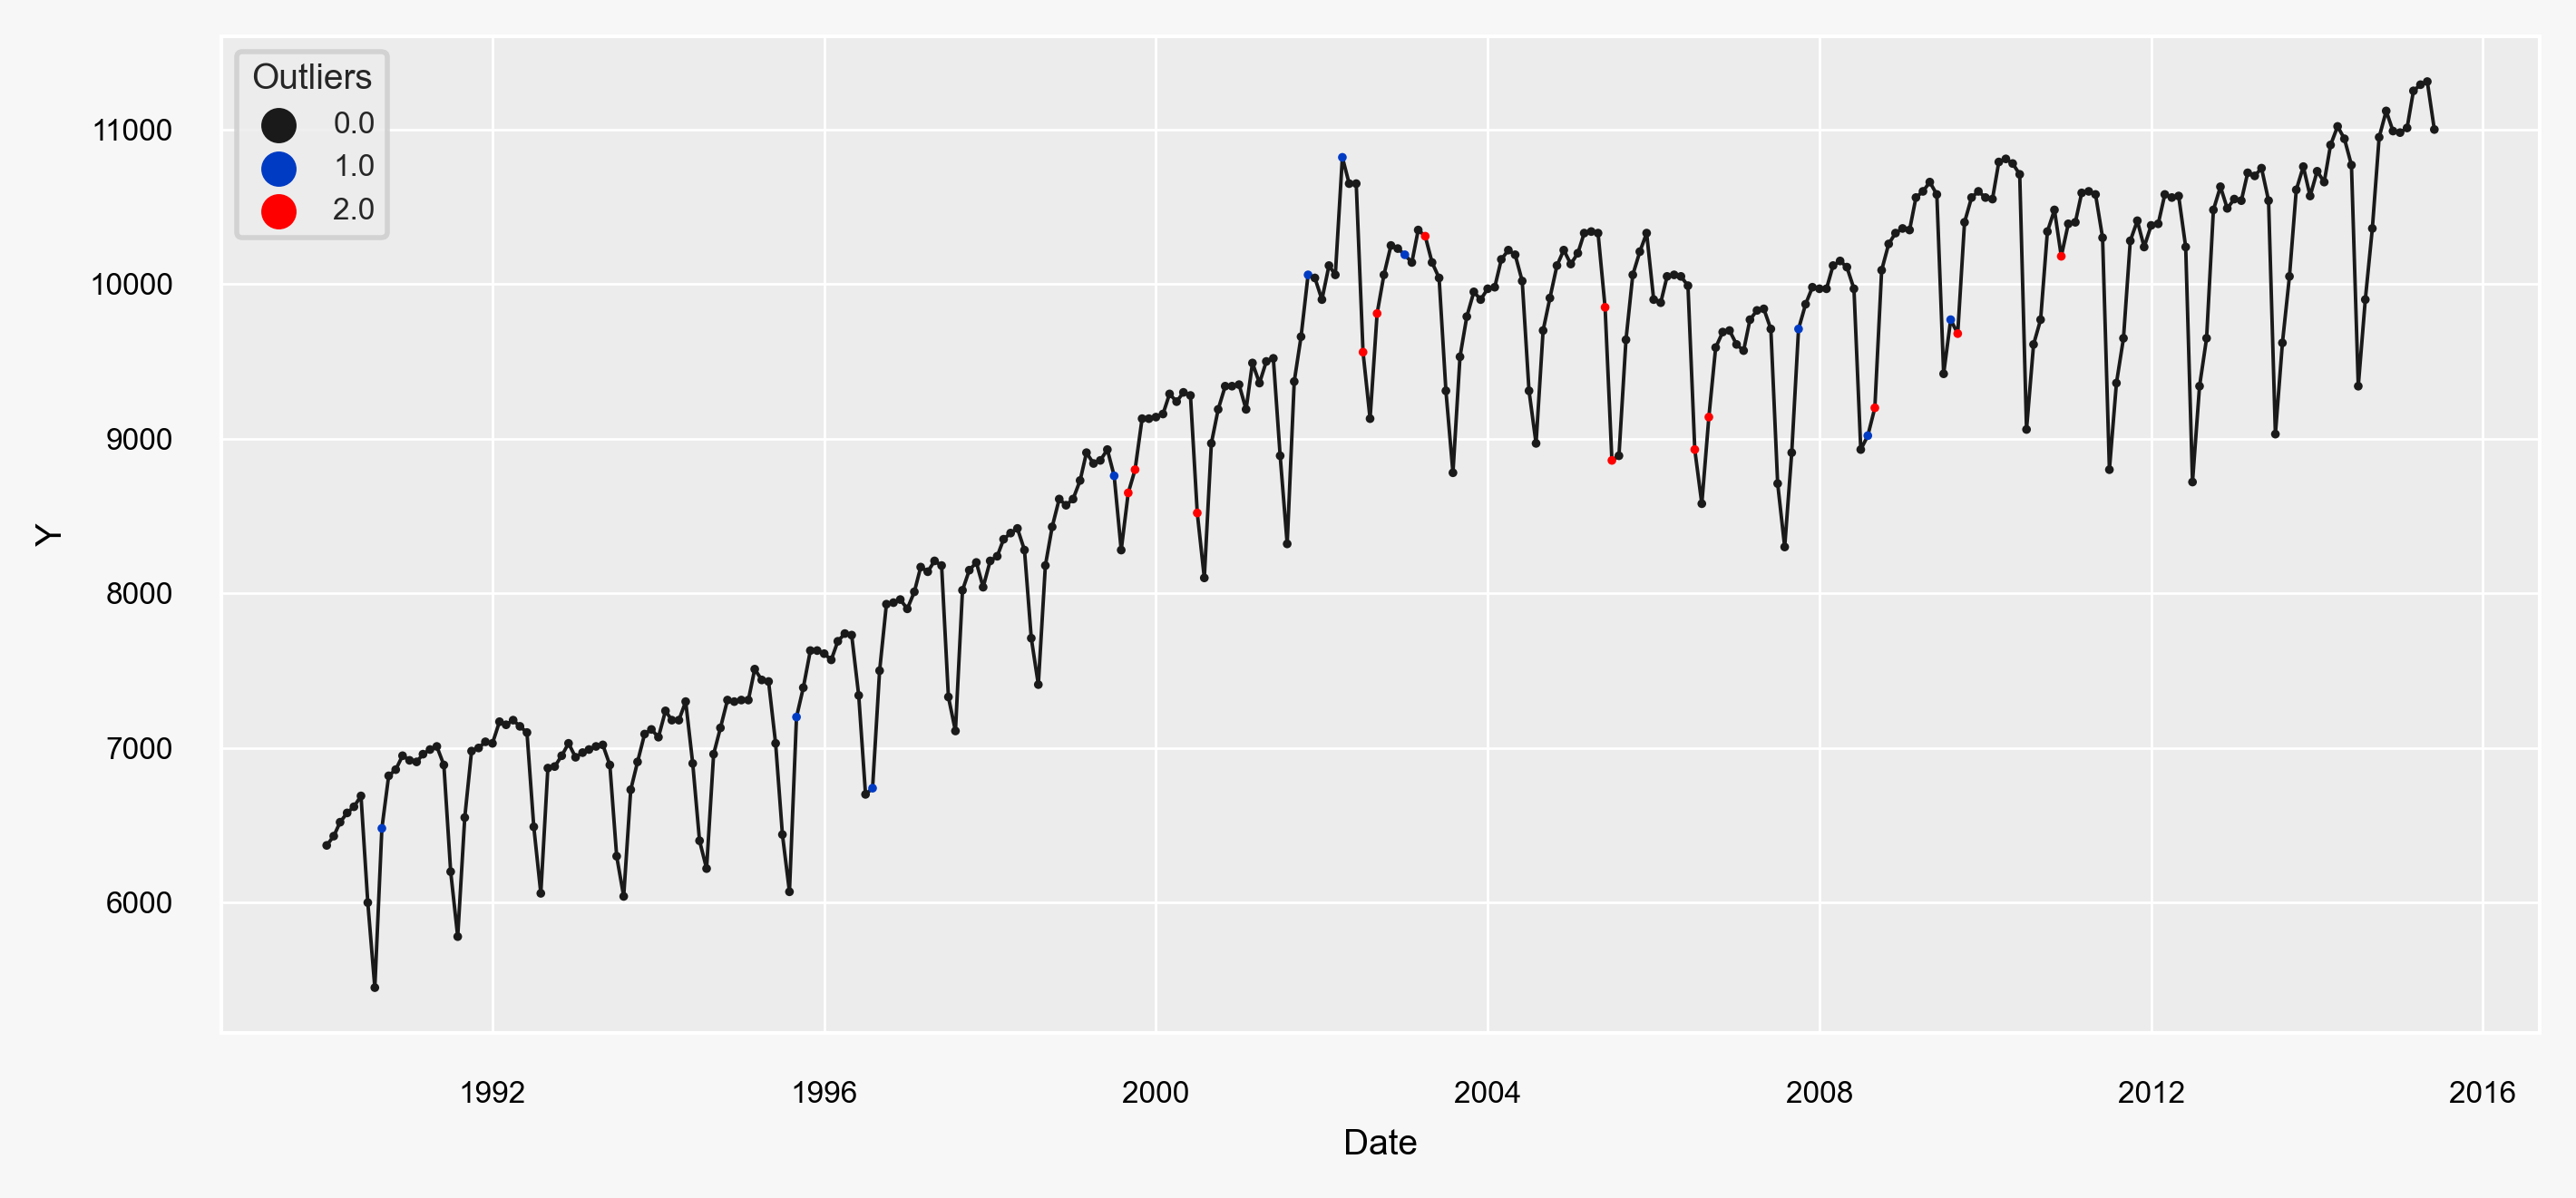

In [50]:
Outliers = pd.DataFrame({'Outliers': Outliers_train['Pos_outliers'] + 2*Outliers_train['Neg_outliers']})
Outliers_vis = pd.concat([train, Outliers], axis=1).fillna(0)

with plt.rc_context(rc={'figure.dpi': 400, 'axes.labelsize': 7, 
                          'xtick.labelsize': 6, 'ytick.labelsize': 6,
                          'legend.fontsize': 6, 'legend.title_fontsize': 7}):

    fig, ax = plt.subplots(2, 1, figsize=(7, 6))
    
    sns.lineplot(ax=ax[0], x=train['Date'], y=train['Y'],
                 color='k', lw=0.7, zorder=5)
    
    sns.scatterplot(ax=ax[0], x=Outliers_vis['Date'], y=Outliers_vis['Y'], 
                    s=3, linewidth=0, zorder=10,
                    hue=Outliers_vis['Outliers'], palette=['k', '#003bc4', '#ff0000'])
        
    ax[1].set_visible(False)

    plt.tight_layout(pad=0.3)
    plt.show()

In [52]:
X_train_1 = pd.concat([X_train, Outliers_train], axis=1).fillna(0)
X_test_1 = pd.concat([X_test, Outliers_test], axis=1).fillna(0)

model_0_b = auto_arima(y=Y_train, X=X_train_1, start_p=0, d=None, start_q=0, 
                       max_p=4, max_d=2, max_q=4, 
                       start_P=0, D=None, start_Q=0, max_P=3, max_D=1, max_Q=3, max_order=None,
                       start_params=None,
                       stepwise=True, maxiter=30,
                       m=12, seasonal=True, stationary=False, 
                       information_criterion='aic', 
                       alpha=0.05, test='kpss', seasonal_test='ocsb',
                       with_intercept='auto', method='lbfgs',
                       suppress_warnings=True, error_action='trace', trace=False)

model_0_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  306
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood               -1928.106
Date:                            Wed, 16 Aug 2023   AIC                           3872.212
Time:                                    21:32:09   BIC                           3901.974
Sample:                                         0   HQIC                          3884.116
                                            - 306                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
mean_Month       1.3354      0.049     27.449      0.000       1.240       1.431
Flag_0        -465.6858     88.631     -5.254      0.000    -639.400    -291.972
Flag_1         424.3086    100.767      4.211      0.000     226.810     621.808
Pos_outliers   254.1258     21.532     11.802      0.000     211.923     296.329
Neg_outliers  -181.7737     23.979     -7.580      0.000    -228.773    -134.775
ar.L1           -0.1656      0.060     -2.745      0.006      -0.284      -0.047
ar.S.L12         0.4605      0.053      8.744      0.000       0.357       0.564
sigma2        1.833e+04   1256.901     14.586      0.000    1.59e+04    2.08e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                20.35
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.06
Prob(H) (two-sided):                  0.91   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
model_p_0_b = model_0_b.predict(n_periods=18, X=X_test_1, return_conf_int=True)
mean_squared_error(Y_test, model_p_0_b[0], squared=False).round(2)

332.7

### 3.3 Residual analysis <a class="anchor" id = "III_3_3"></a>

<p><div style = "text-align: justify; font-size: 14px">To make sure that all necessary assumptions hold (homoscedasticity, no autocorrelation and normality for constructing PI), we can make some useful plots and analyse them:</div></p>

In [54]:
resid_0_b = pd.DataFrame({'Res': drop_obs(model_0_b)})

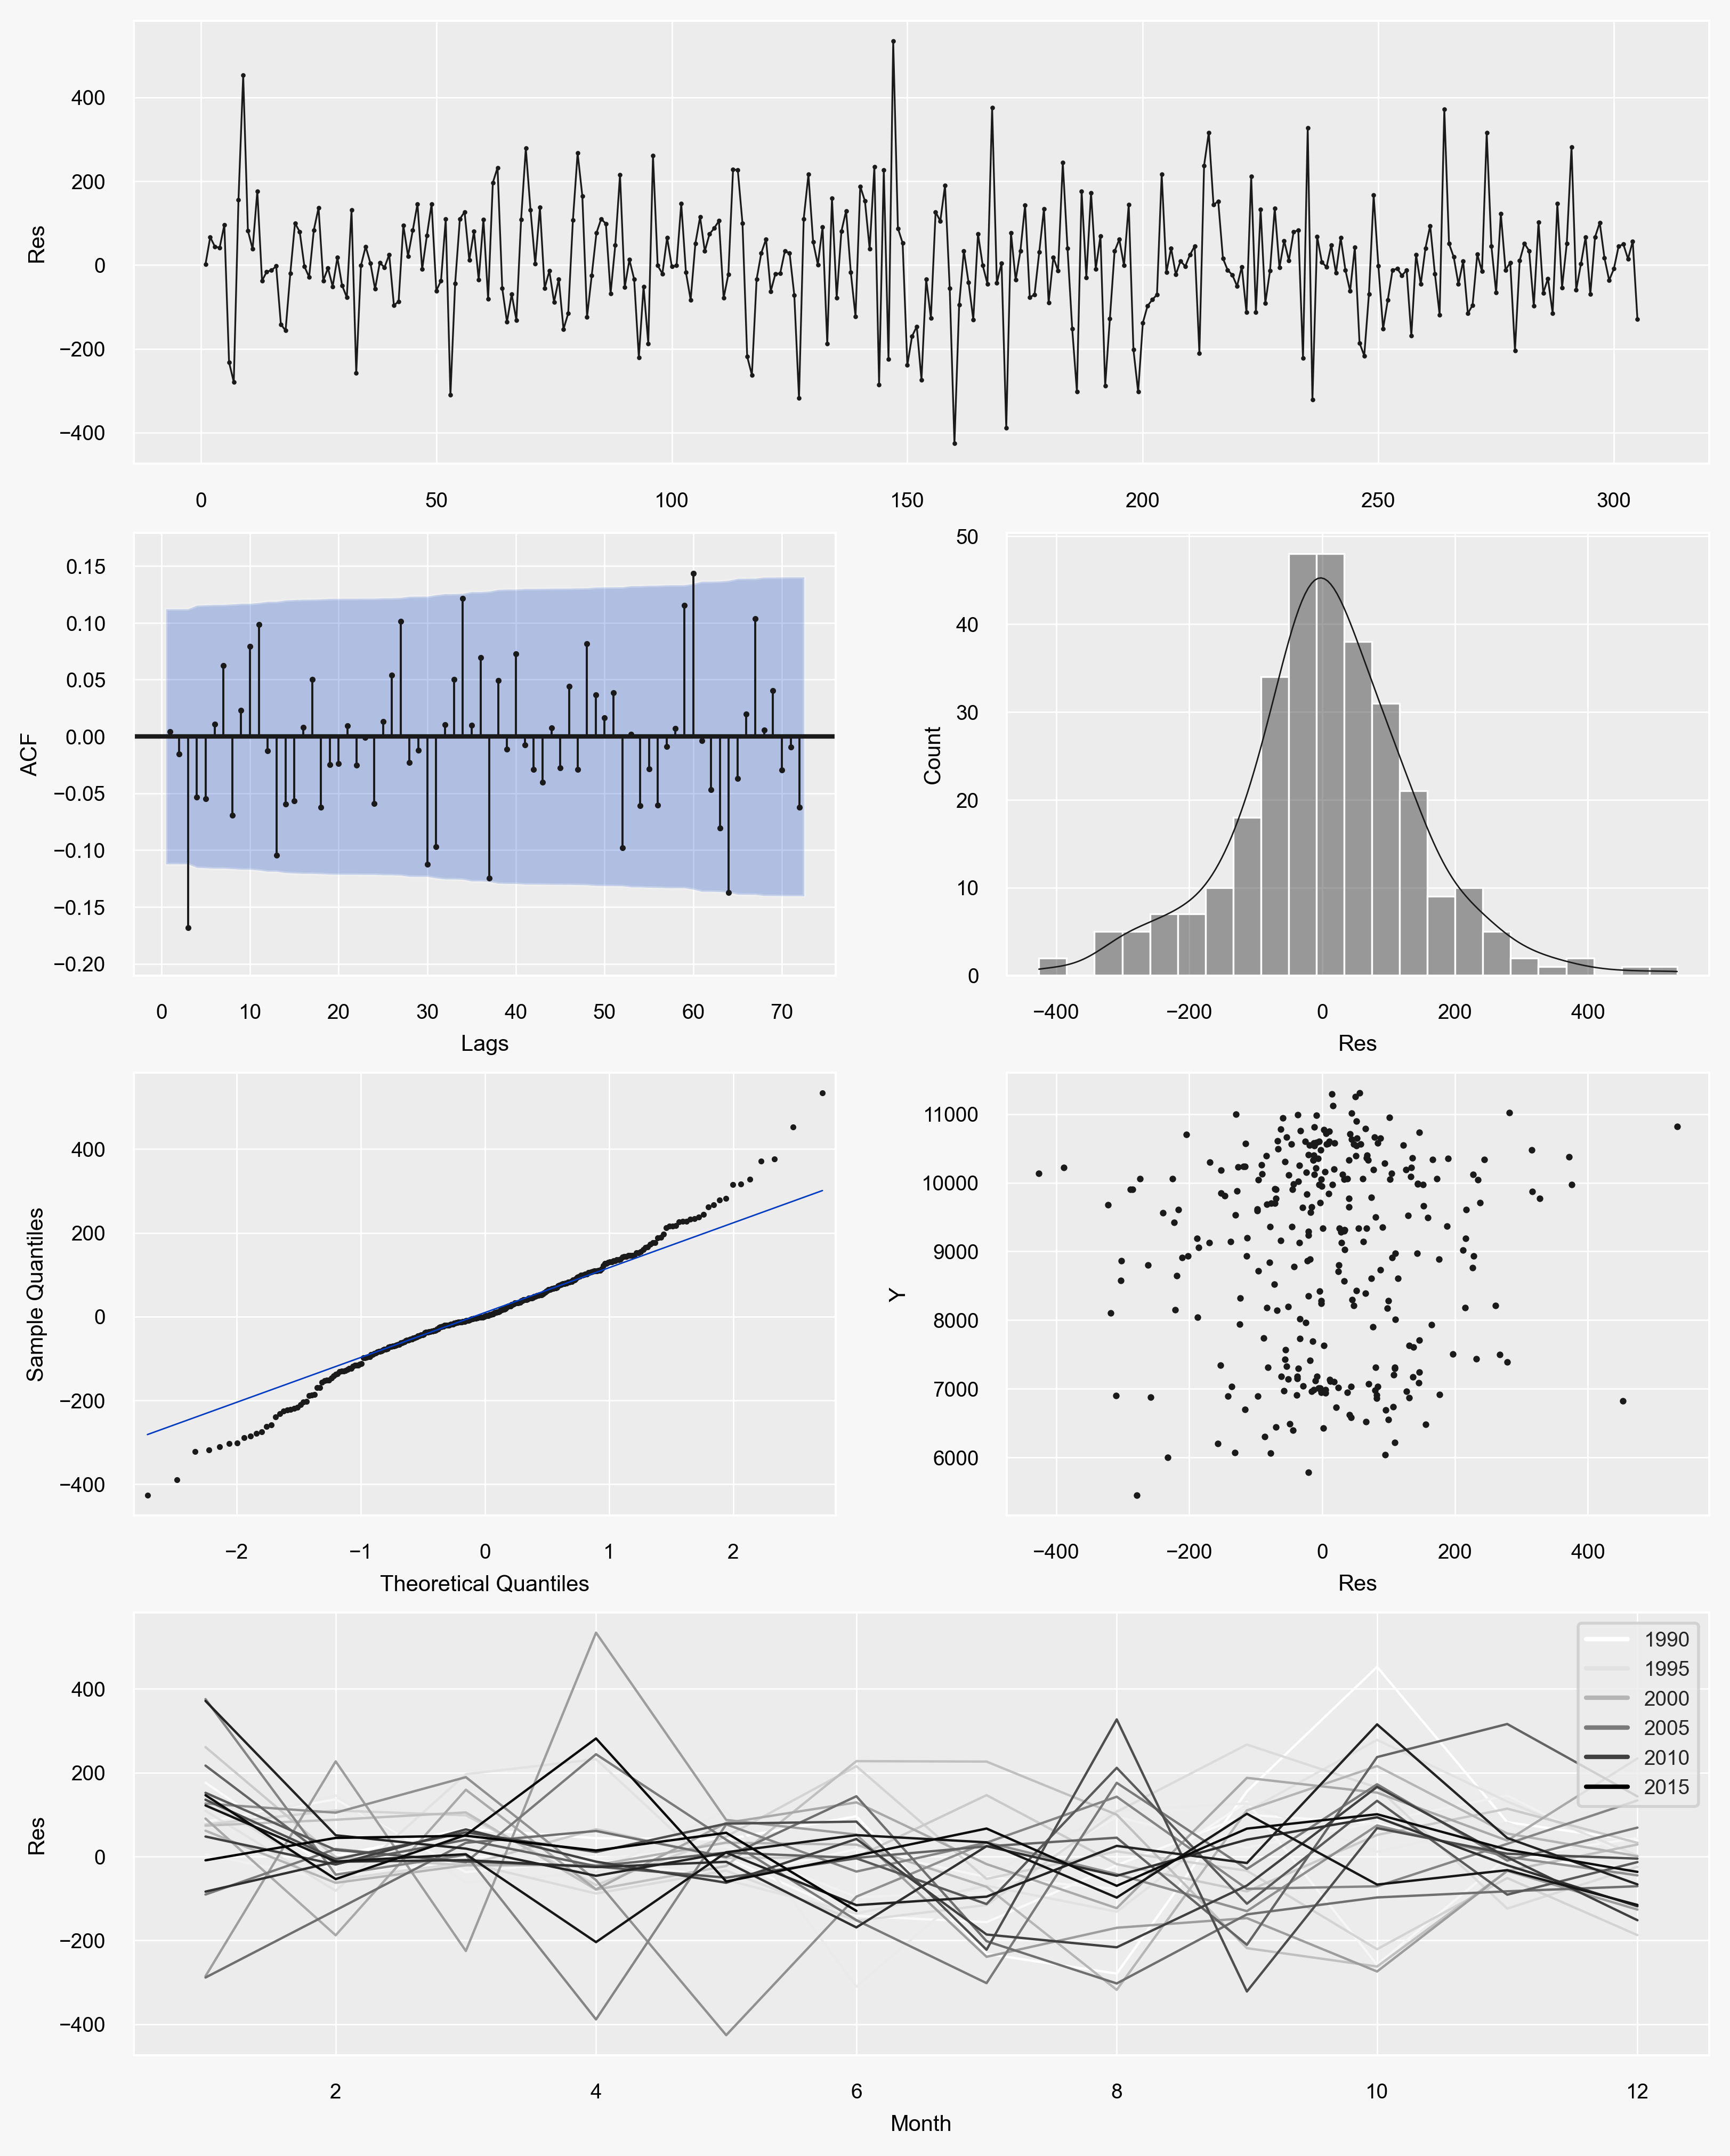

In [55]:
with plt.rc_context(rc={'figure.dpi': 400, 'axes.labelsize': 7.5, 
                        'xtick.labelsize': 7, 'ytick.labelsize': 7, 
                        'legend.fontsize': 7, 'legend.title_fontsize': 7.5}):
    
    fig = plt.figure(constrained_layout=True, figsize=(8, 10))

    gs = fig.add_gridspec(4, 4)

    f_ax_1 = fig.add_subplot(gs[0:1, 0:4])
    f_ax_2 = fig.add_subplot(gs[1, 0:2])
    f_ax_3 = fig.add_subplot(gs[1, 2:4])
    f_ax_4 = fig.add_subplot(gs[2, 0:2])
    f_ax_5 = fig.add_subplot(gs[2, 2:4])
    f_ax_6 = fig.add_subplot(gs[3:4, 0:4])
    
    # Plot № 1
    
    sns.lineplot(ax=f_ax_1, x=resid_0_b.index, y=resid_0_b['Res'],
                 color='k', lw=0.6, marker='o', markeredgecolor='k', markersize=0.8)
    
    # Plots № 2 and № 3
    
    tsaplots.plot_acf(ax=f_ax_2, x=resid_0_b['Res'], lags=72, zero=False, auto_ylims=True,
                      markerfacecolor='k', markeredgecolor='k', markersize=1, title=None,
                      vlines_kwargs={'colors': 'k', 'linewidth': 0.7})
    
    f_ax_2.set_xlabel('Lags', fontsize=7.5)
    f_ax_2.set_ylabel('ACF', fontsize=7.5)
    f_ax_2.collections[1].set_facecolor('#003bc4')
    f_ax_2.lines[0].set_color('k')
    
    sns.histplot(ax=f_ax_3, x=resid_0_b['Res'], alpha=0.4, color='k', linewidth=0.6,
                 kde=True, line_kws={'linewidth': 0.5})
    
    # Plot № 4
    
    sm.qqplot(ax=f_ax_4, data=resid_0_b['Res'], line='q', 
              markerfacecolor='k', markeredgecolor='k', markersize=1)
    
    f_ax_4.get_lines()[1].set_color('#003bc4')
    f_ax_4.get_lines()[1].set_linewidth('0.5')

    # Plot № 5
    
    sns.scatterplot(ax=f_ax_5, x=resid_0_b['Res'], y=train['Y'],
                    color='k', s=5, linewidth=0)
    
    # Plot № 6
    
    sns.lineplot(ax=f_ax_6, x=train['Month'][1:], y=resid_0_b['Res'], 
                 hue=train['Year'], palette='Greys', linewidth=0.8)  # legend='full'
    
    f_ax_6.legend(ncol=1, loc='upper right')
    
    plt.show()

### 3.4 Results <a class="anchor" id = "III_3_4"></a>

In [56]:
results_0 = pd.DataFrame({'Y': test['Y'], 'Forecast': model_p_0_b[0], 'Date': test['Date']})
results_0 = pd.melt(results_0, id_vars=['Date'], value_vars=['Y', 'Forecast'])
results_0 = results_0.reset_index()

results_0 = results_0.join(pd.DataFrame(model_p_0[1], columns=('L', 'U'),
                                        index=range(len(test), len(test) + 18)), 
                           on='index', how='left')

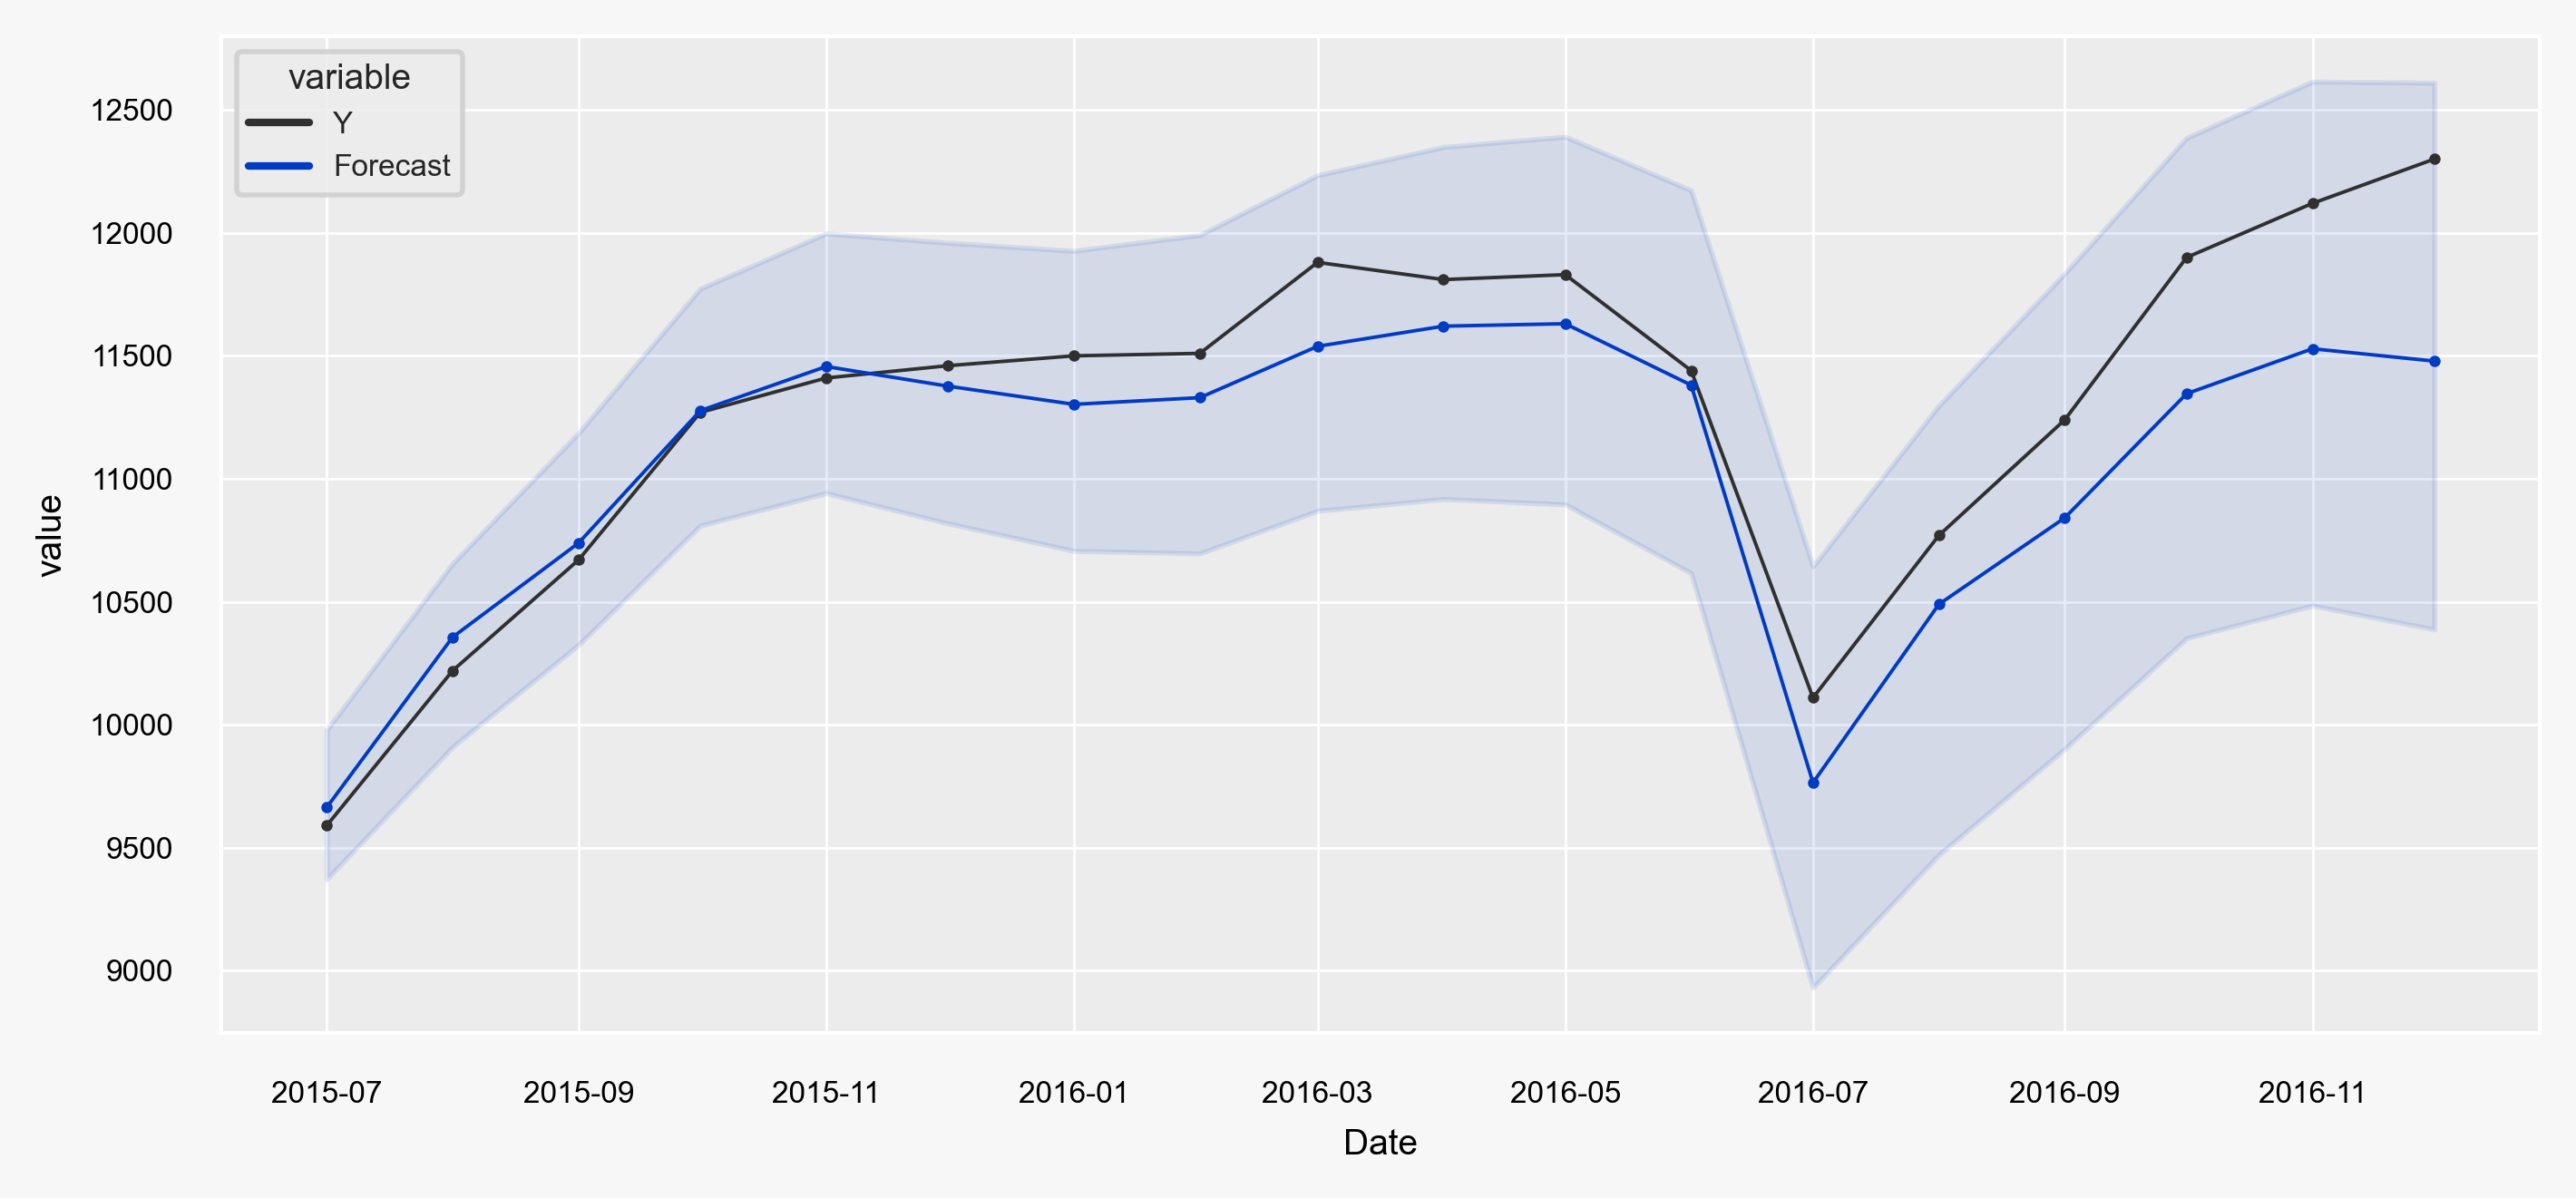

In [57]:
with plt.rc_context(rc={'figure.dpi': 400, 'axes.labelsize': 7, 
                        'xtick.labelsize': 6, 'ytick.labelsize': 6, 
                        'legend.fontsize': 6, 'legend.title_fontsize': 7}):
    
    fig, ax = plt.subplots(2, 1, figsize=(7, 6))
    
    sns.lineplot(ax=ax[0], x=results_0['Date'], y=results_0['value'],
                 hue=results_0['variable'], palette=['#303030', '#003bc4'],
                 markeredgecolor=None, markersize=1.5, lw=0.7, marker='o')

    ax[0].fill_between(x=results_0.loc[results_0['variable'] == 'Forecast', 'Date'], 
                       y1=results_0.loc[results_0['variable'] == 'Forecast', 'L'],
                       y2=results_0.loc[results_0['variable'] == 'Forecast', 'U'], 
                       color='#003bc4', alpha=0.1)
        
    ax[1].set_visible(False)

    plt.tight_layout(pad=0.3)
    plt.show()

<p><div style = "text-align: justify; font-size: 14px">Although the $RMSE$ score was quite low, particularly if we compare it to the average value per month, it is evident that after a certain point the forecast was consistently lower than the observed data. Why is that? Let's visualise a past few years:</div></p>

In [59]:
new_idx = (Data['Date'] > '2012-01-01')
after_2012 = Data.loc[new_idx]

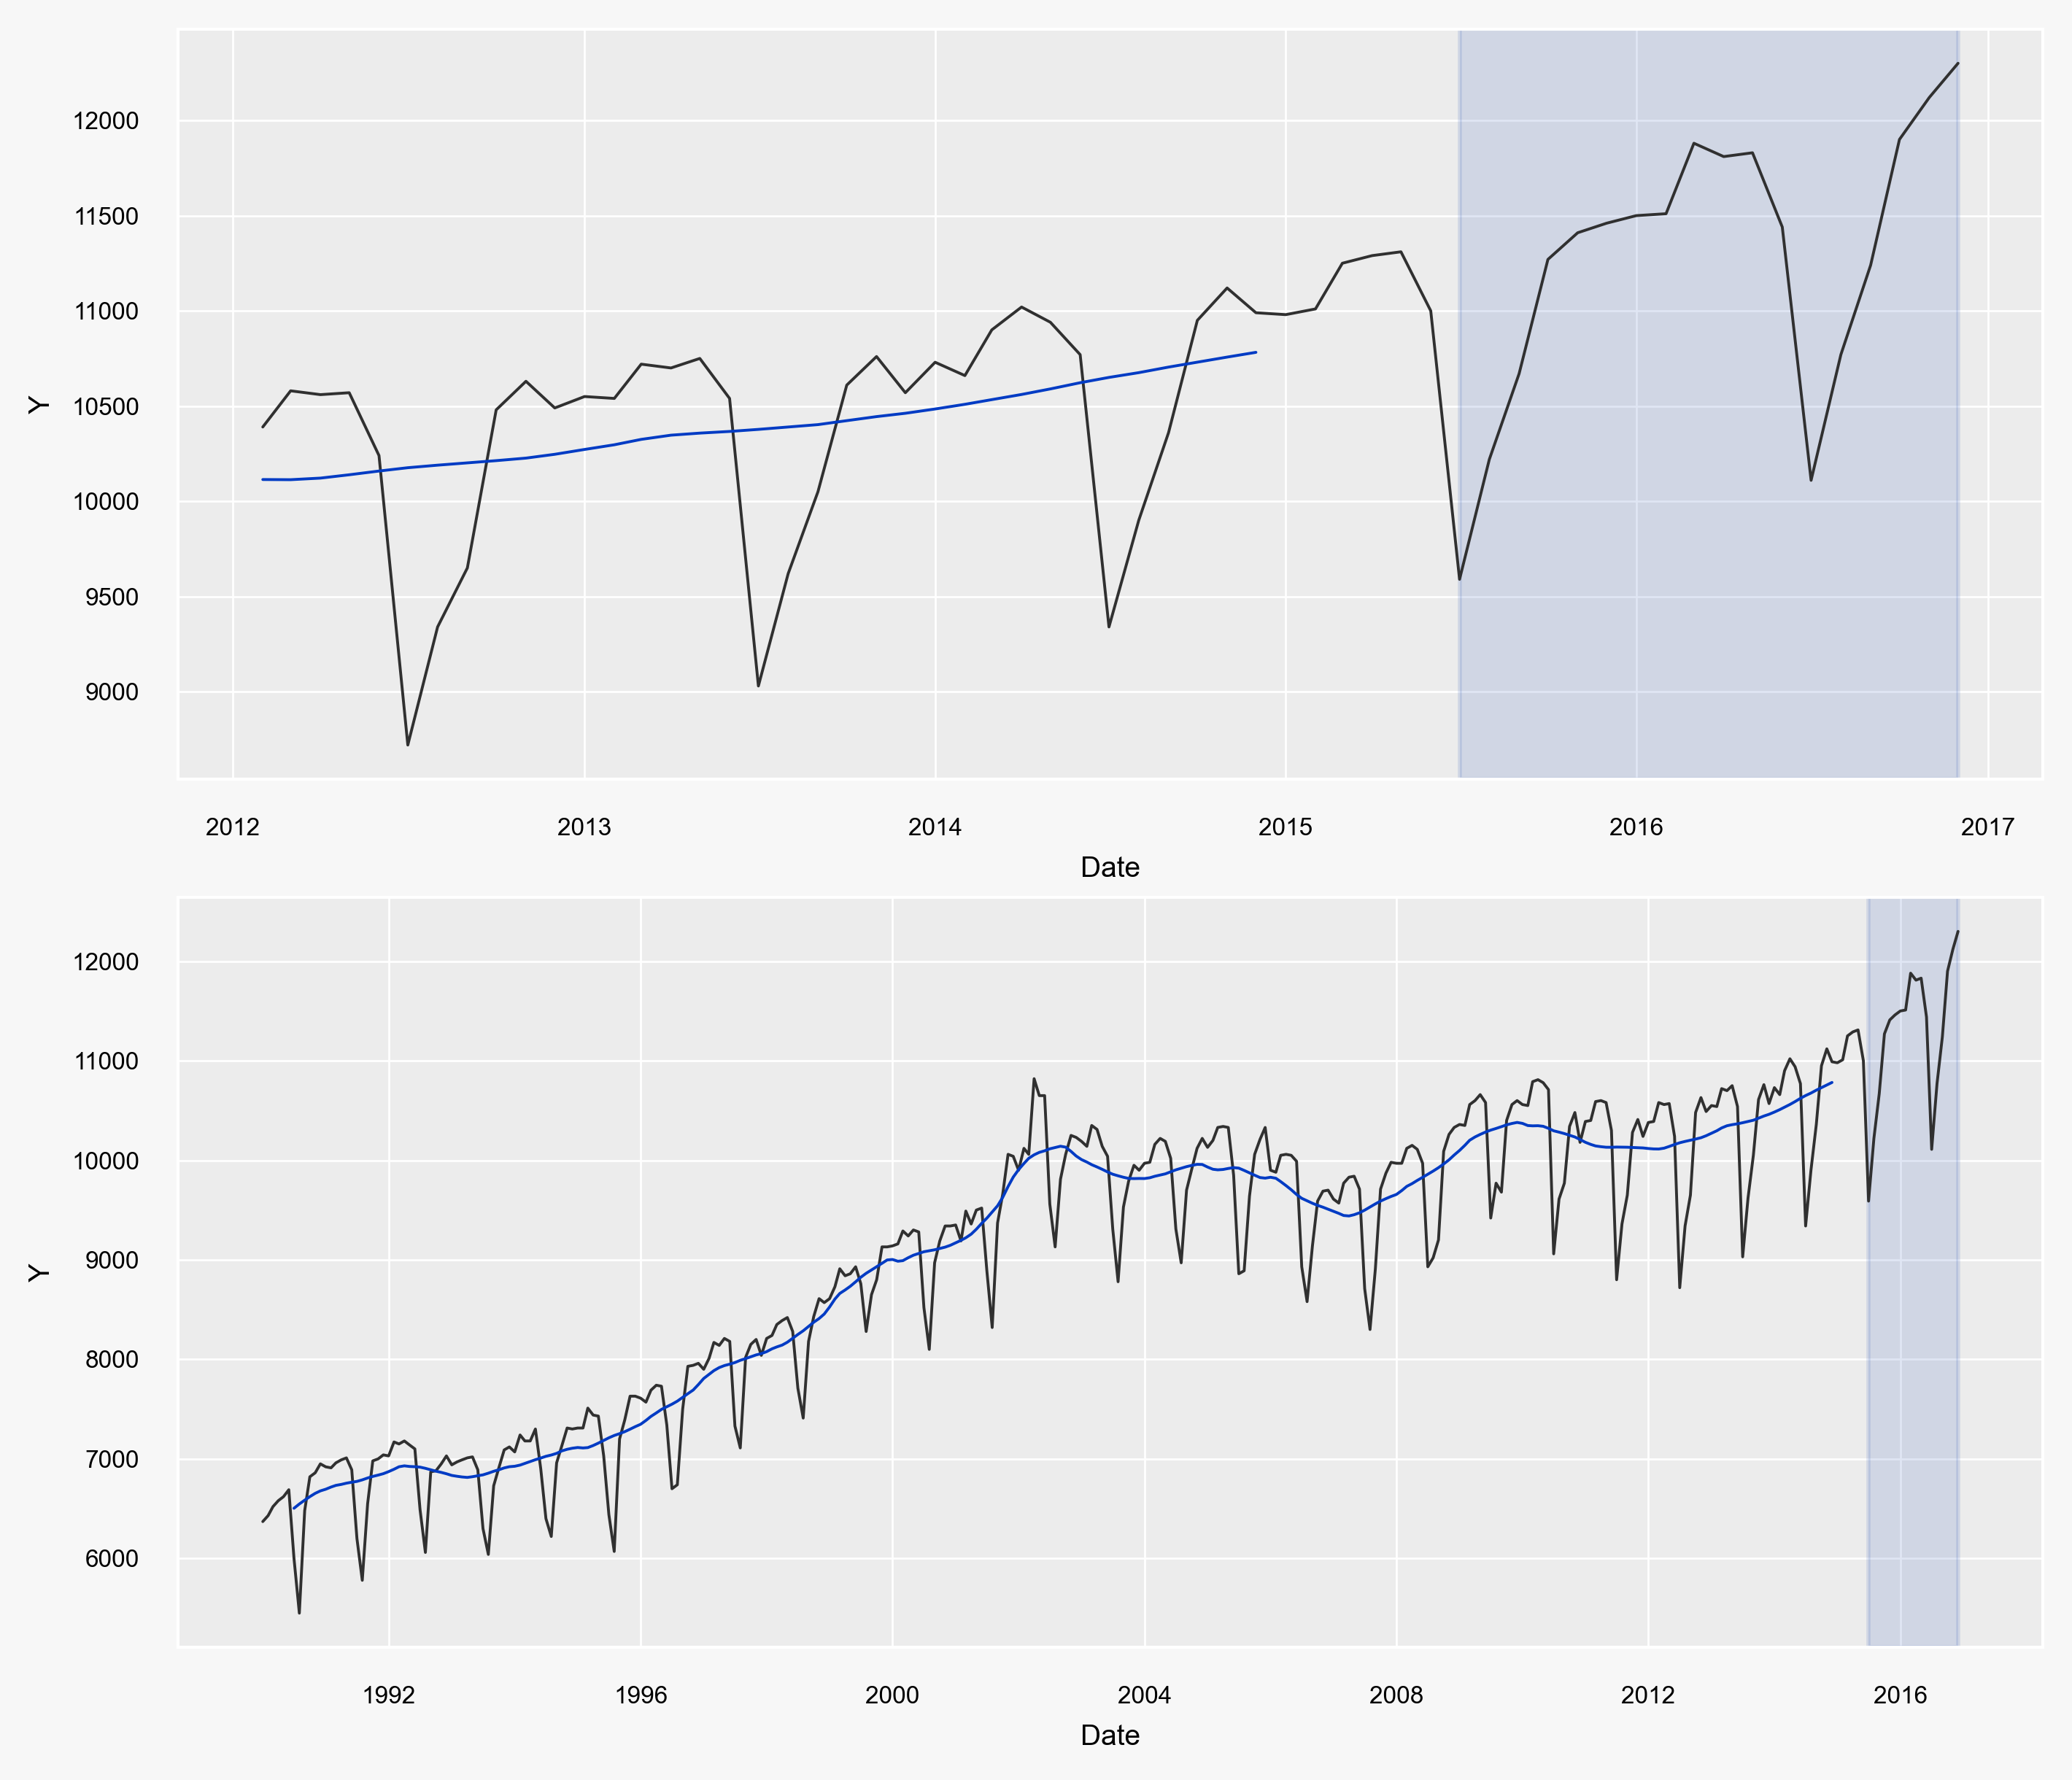

In [61]:
with plt.rc_context(rc={'figure.dpi': 400, 'axes.labelsize': 7, 
                        'xtick.labelsize': 6, 'ytick.labelsize': 6, 
                        'legend.fontsize': 6, 'legend.title_fontsize': 7}):
    
    fig, ax = plt.subplots(2, 1, figsize=(7, 6))
    
    sns.lineplot(ax=ax[0], x=after_2012['Date'], y=after_2012['Y'], 
                 color='#303030', lw=0.7)
    
    sns.lineplot(ax=ax[0], x=after_2012['Date'], y=decomp_m_results['Trend'],
                 color='#003bc4', lw=0.7)
    
    ax[0].axvspan(xmin=pd.to_datetime('2015-07-01'), xmax=pd.to_datetime('2016-12-01'),
                    ymin=0, ymax=11000, alpha=0.15, color='#3059b8')
        
    sns.lineplot(ax=ax[1], x=Data['Date'], y=Data['Y'], 
                 color='#303030', lw=0.7)
    
    sns.lineplot(ax=ax[1], x=Data['Date'], y=decomp_m_results['Trend'],
                 color='#003bc4',lw=0.7)
    
    ax[1].axvspan(xmin=pd.to_datetime('2015-07-01'), xmax=pd.to_datetime('2016-12-01'),
                  ymin=0, ymax=11000, alpha=0.15, color='#3059b8')

    plt.tight_layout(pad=0.3)
    plt.show()

<p><div style = "text-align: justify; font-size: 14px">As you can see, the test set data was higher (quite significantly) than that stored in the train set. As a result, our model could not fully pick up on that, yielding slightly lower values than anticipated. Can we do something about it? Most certainly!</div></p>

## 4. Building a model (making reasonable assumptions) <a class="anchor" id = "III_4"></a>

<p><div style = "text-align: justify; font-size: 14px">The last 4 years of data (train set) showed a polynomial trend, which was not captured well enough by our model for several reasons: recent observations were overpowered by the previously erratic trend, on top of that, the tendency was not that strong overall. Nevertheless, if we are certain that such trend will prevail – whether it is a scenario-based forecasting or domain knowledge that we rely on – we can incorporate an additional variable into our model.</div></p>

### 4.1 Trend variable <a class="anchor" id = "III_4_1"></a>

<p><div style = "text-align: justify; font-size: 14px">The idea is fairly straightforward: take the trend-cycle component obtained after time series decomposition (the simplest way to estimate a trend) and forecast several recent years (months) that you believe are indicative of the actual tendency:</div></p>

In [62]:
decomp_m_2012 = decomp_m_results.loc[(train['Date'] > '2012-01-01')]

X_idx = list(decomp_m_2012['Trend'].dropna().index)  # Dropping na 
Na, pred_h = decomp_m_2012['Trend'].isna().sum(), 18  # Forecast horizon (6 NA + 18 values we need to predict)
end = len(X_idx) + Na + pred_h

X_OLS = pd.DataFrame({'X': range(1, end + 1), 'X_2': [x**2 for x in range(1, end + 1)]})
X_OLS_tr, X_OLS_te = X_OLS.iloc[0:-(Na + pred_h), ], X_OLS.iloc[-(Na + pred_h):, ]

Y = decomp_m_2012['Trend'].dropna().reset_index(drop=True)

# A simple regression model

OLS_model = sm.OLS(endog = Y, exog = sm.add_constant(X_OLS_tr)).fit()
OLS_model_pred = OLS_model.predict(sm.add_constant(X_OLS_te))

# NA values at the beginning of the trend-cycle list were replaced with the mean
# NA values at the end of the trend-cycle list were dropped

half = int((len(decomp_m_results) / 2))

A = decomp_m_results['Trend'].iloc[0:half].fillna(np.mean(decomp_m_results['Trend'][0:24]))
B = decomp_m_results['Trend'].iloc[half:].dropna()

trend_var = pd.concat([A, B, OLS_model_pred], axis=0).reset_index(drop=True)
trend_var = pd.DataFrame({'Trend': trend_var})
trend_var_tr, trend_var_te = trend_var.iloc[0:-pred_h], trend_var.iloc[-pred_h:]

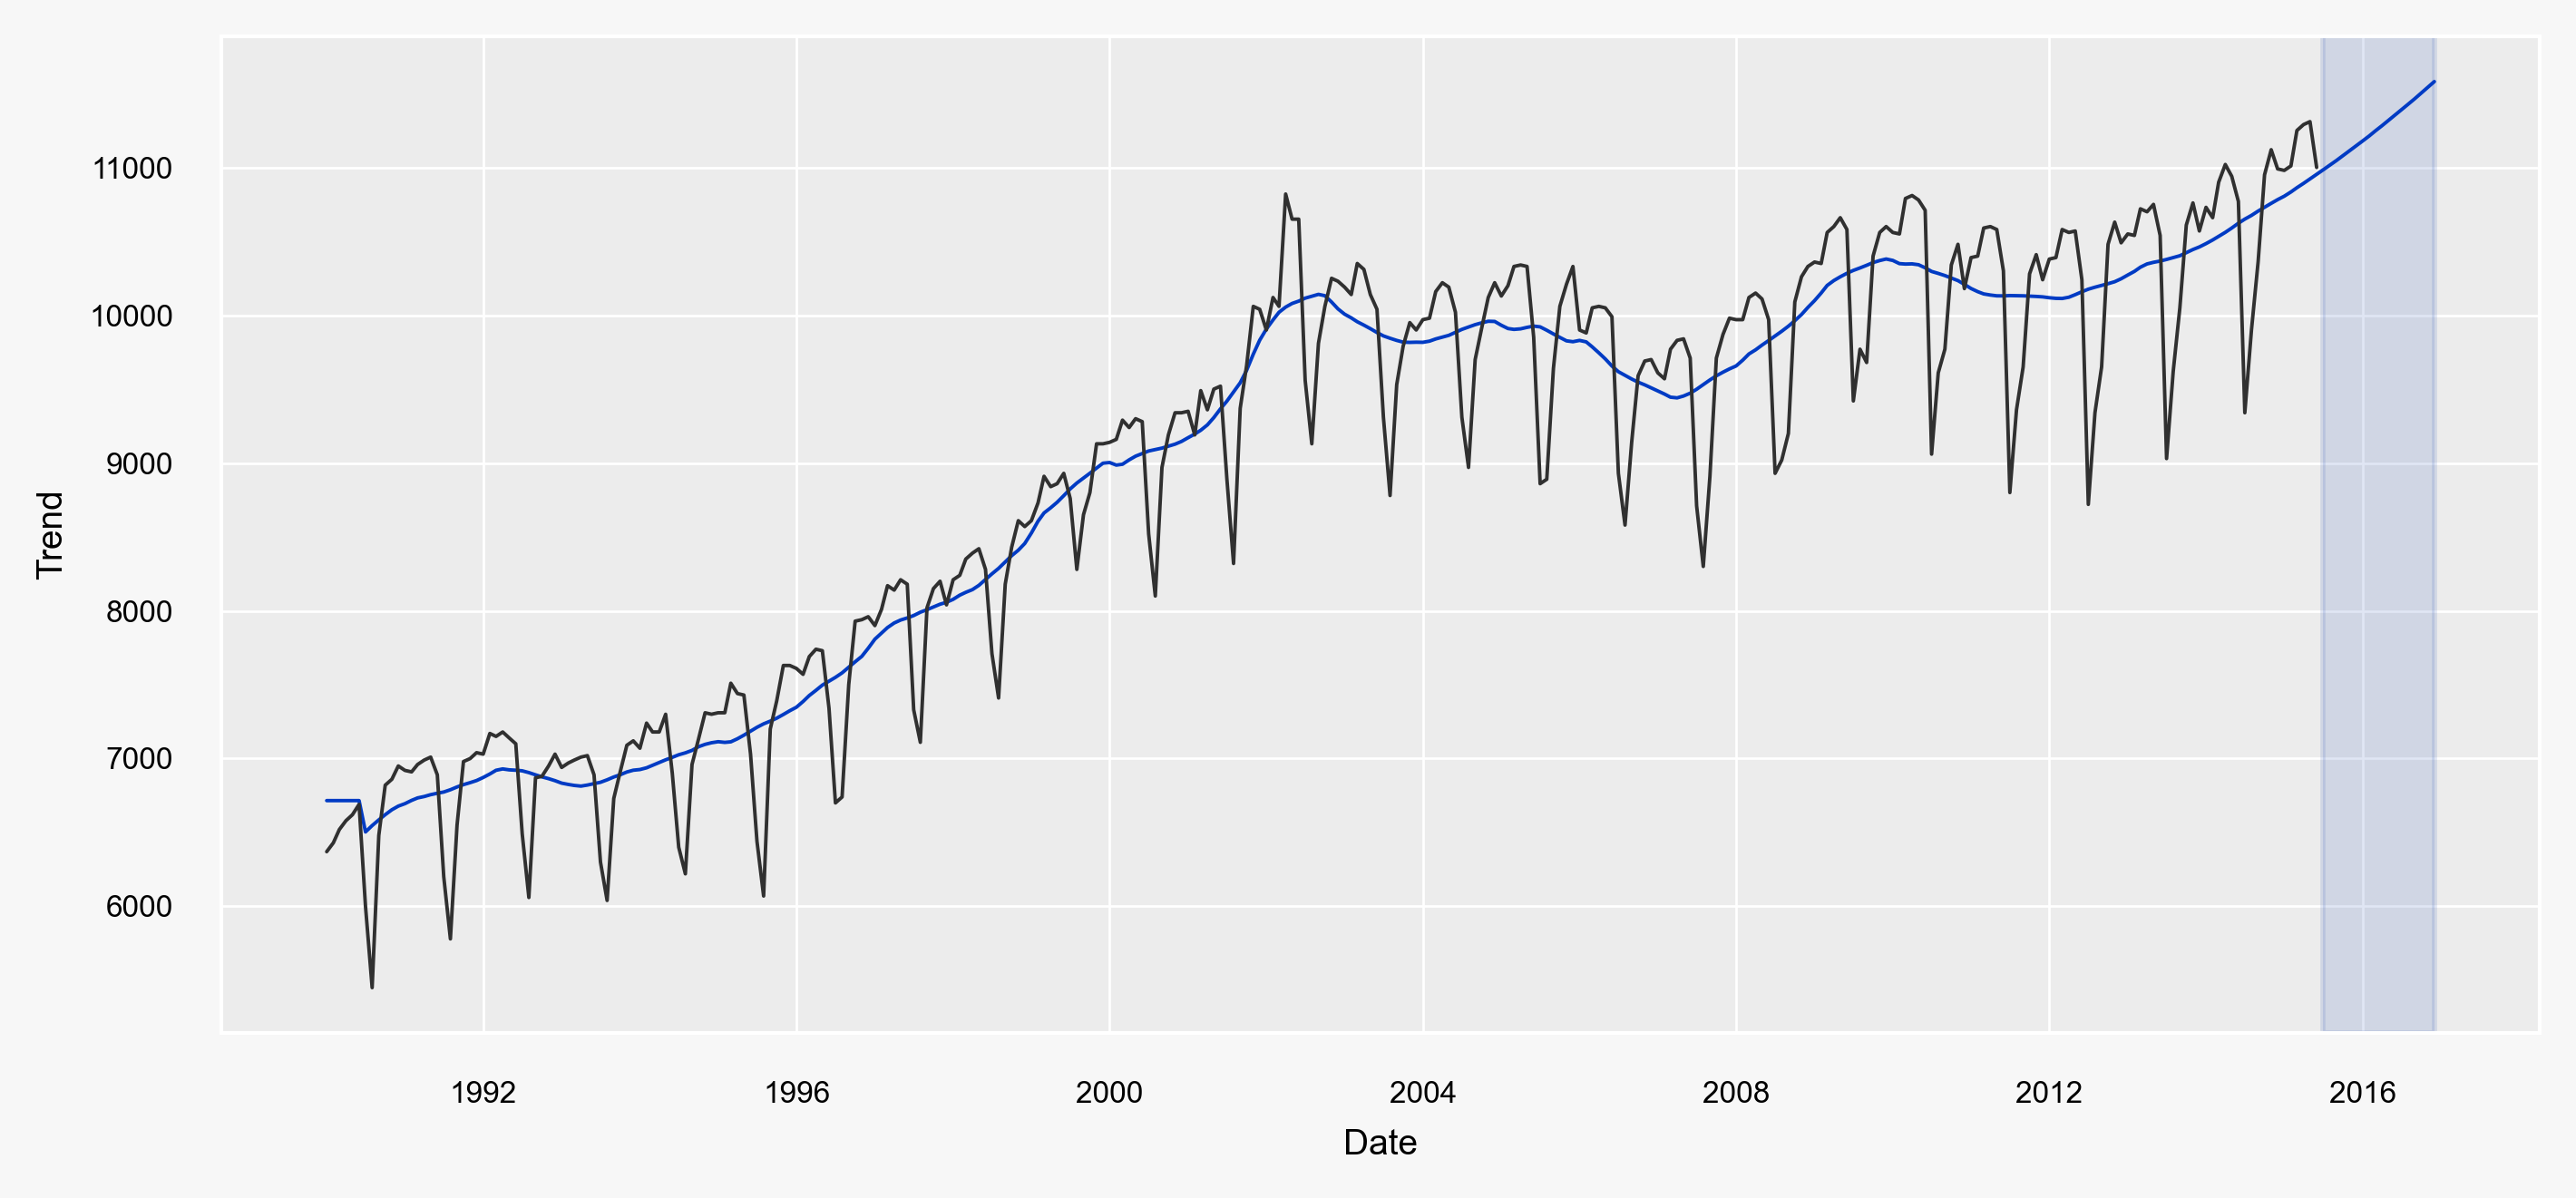

In [65]:
with plt.rc_context(rc={'figure.dpi': 400, 'axes.labelsize': 7, 
                        'xtick.labelsize': 6, 'ytick.labelsize': 6, 
                        'legend.fontsize': 6, 'legend.title_fontsize': 7}):
    
    fig, ax = plt.subplots(2, 1, figsize=(7, 6))
    
    sns.lineplot(ax=ax[0], x=Data['Date'], y=trend_var['Trend'], 
                 color='#003bc4', lw=0.7)
    
    sns.lineplot(ax=ax[0], x=Data['Date'], y=train['Y'], 
                 color='#303030', lw=0.7)
    
    ax[0].axvspan(xmin=pd.to_datetime('2015-07-01'), xmax=pd.to_datetime('2016-12-01'),
                  ymin=0, ymax=11000, alpha=0.15, color='#3059b8')
    
    ax[1].set_visible(False)
    
    plt.tight_layout(pad=0.3)
    plt.show()

### 4.2 Model tuning <a class="anchor" id = "III_4_2"></a>

In [66]:
X_train_2 = pd.concat([M_enc_train, Flags_tr, trend_var_tr], axis=1)
X_test_2 = pd.concat([M_enc_test, Flags_te, trend_var_te], axis =1)

model_1 = auto_arima(y=Y_train, X=X_train_2, start_p=0, d=None, start_q=0, 
                     max_p=4, max_d=2, max_q=4, 
                     start_P=0, D=None, start_Q=0, max_P=3, max_D=1, max_Q=3, max_order=8,
                     start_params=None,
                     stepwise=True, maxiter=30,
                     m=12, seasonal=True, stationary=False, 
                     information_criterion='aic', 
                     alpha=0.05, test='kpss', seasonal_test='ocsb',
                     with_intercept='auto', method='lbfgs',
                     suppress_warnings=True, error_action='trace', trace=False)

model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  306
Model:             SARIMAX(4, 1, 2)x(2, 0, [1], 12)   Log Likelihood               -1938.518
Date:                              Wed, 16 Aug 2023   AIC                           3907.035
Time:                                      21:45:55   BIC                           3962.840
Sample:                                           0   HQIC                          3929.356
                                              - 306                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0343      0.118     -0.290      0.772      -0.266       0.197
mean_Month     0.1639      0.194      0.845      0.398      -0.216       0.544
Flag_0      -525.0960    342.741     -1.532      0.126   -1196.855     146.663
Flag_1       384.1878    158.783      2.420      0.016      72.980     695.396
Trend          1.0441      0.056     18.727      0.000       0.935       1.153
ar.L1         -0.6163      0.157     -3.933      0.000      -0.923      -0.309
ar.L2          0.4355      0.106      4.118      0.000       0.228       0.643
ar.L3         -0.1310      0.104     -1.261      0.207      -0.335       0.073
ar.L4         -0.2023      0.094     -2.156      0.031      -0.386      -0.018
ma.L1          0.0063      0.137      0.046      0.964      -0.263       0.276
ma.L2         -0.9681      0.138     -7.037      0.000      -1.238      -0.698
ar.S.L12       1.1042      0.188      5.858      0.000       0.735       1.474
ar.S.L24      -0.1246      0.175     -0.713      0.476      -0.467       0.218
ma.S.L12      -0.6470      0.183     -3.529      0.000      -1.006      -0.288
sigma2      2.576e+04   2416.374     10.659      0.000     2.1e+04    3.05e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                93.20
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.37
Prob(H) (two-sided):                  0.39   Kurtosis:                         5.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [67]:
model_p_1 = model_1.predict(n_periods=18, X=X_test_2, return_conf_int=True)
mean_squared_error(Y_test, model_p_1[0], squared=False).round(2)

169.0

<p><div style = "text-align: justify; font-size: 14px">Needless to say, the result was superior.</div></p>

### 4.3 Residual analysis <a class="anchor" id = "III_4_3"></a>

In [68]:
resid_1 = pd.DataFrame({'Res': drop_obs(model_1)})

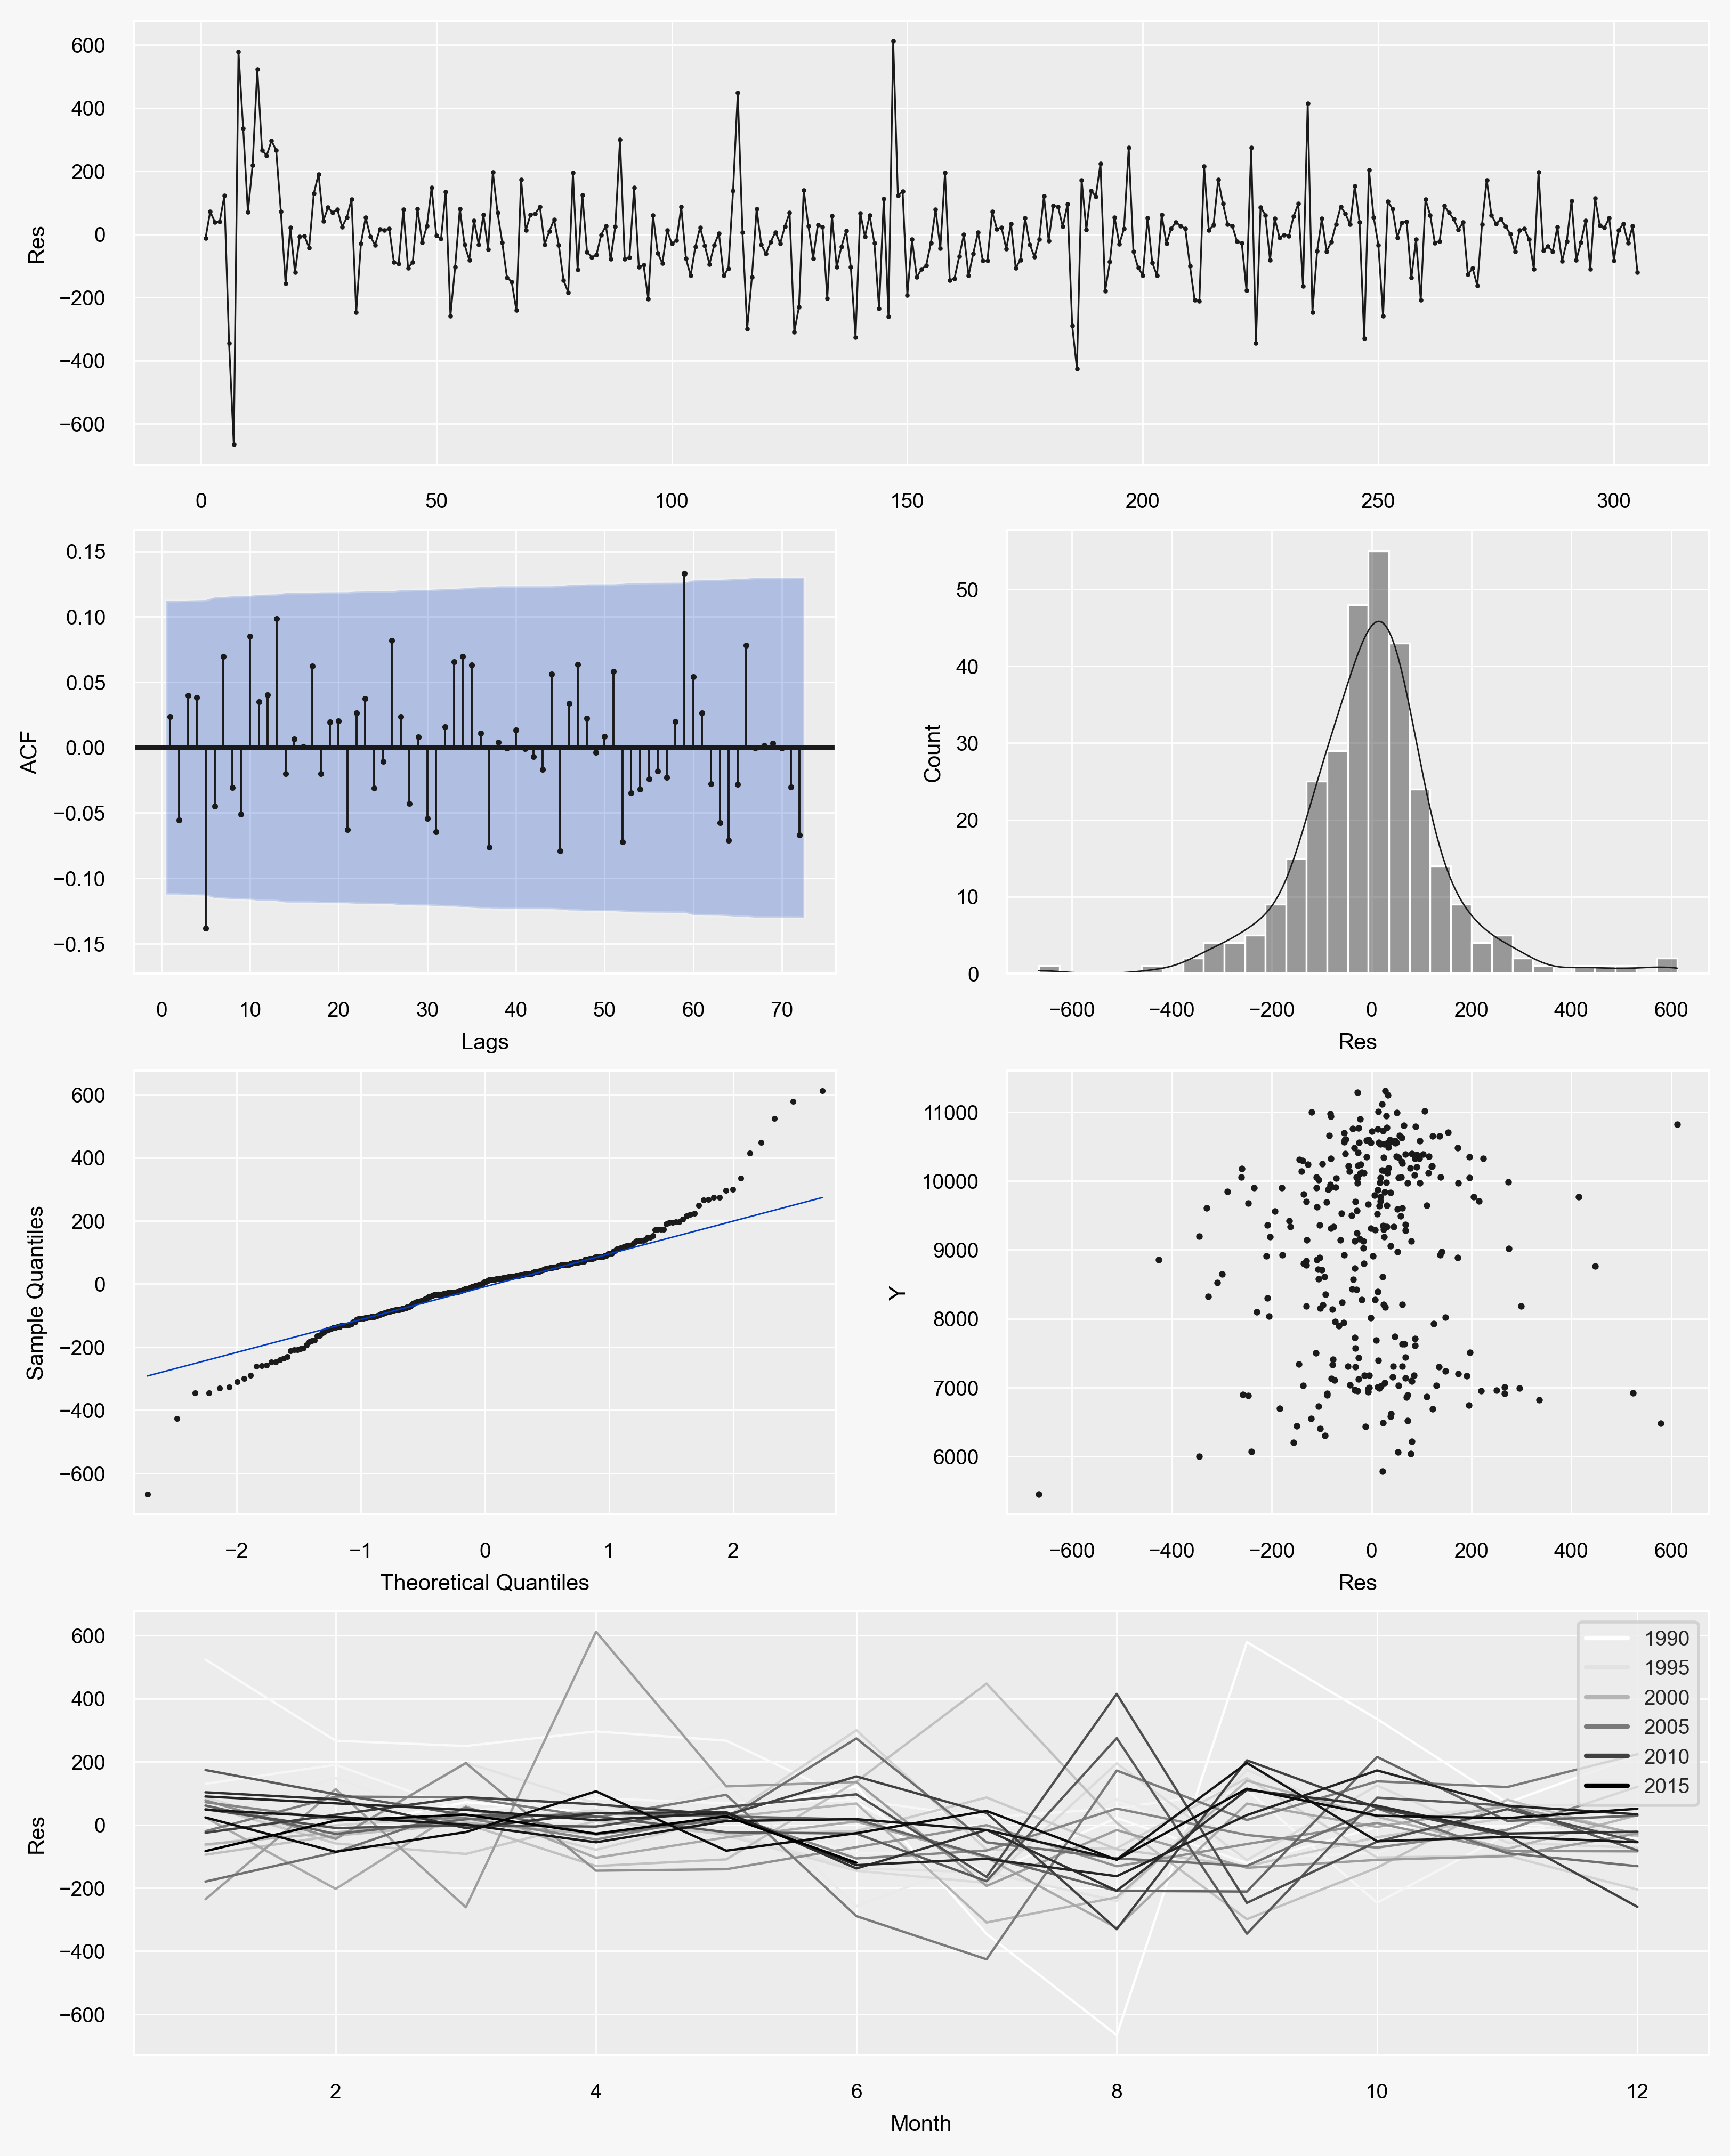

In [69]:
with plt.rc_context(rc={'figure.dpi': 400, 'axes.labelsize': 7.5, 
                        'xtick.labelsize': 7, 'ytick.labelsize': 7, 
                        'legend.fontsize': 7, 'legend.title_fontsize': 7.5}):
    
    fig = plt.figure(constrained_layout=True, figsize=(8, 10))

    gs = fig.add_gridspec(4, 4)

    f_ax_1 = fig.add_subplot(gs[0:1, 0:4])
    f_ax_2 = fig.add_subplot(gs[1, 0:2])
    f_ax_3 = fig.add_subplot(gs[1, 2:4])
    f_ax_4 = fig.add_subplot(gs[2, 0:2])
    f_ax_5 = fig.add_subplot(gs[2, 2:4])
    f_ax_6 = fig.add_subplot(gs[3:4, 0:4])
    
    # Plot № 1
    
    sns.lineplot(ax=f_ax_1, x=resid_1.index, y=resid_1['Res'],
                 color='k', lw=0.6, marker='o', markeredgecolor='k', markersize=0.8)
    
    # Plots № 2 and № 3
    
    tsaplots.plot_acf(ax=f_ax_2, x=resid_1['Res'], lags=72, zero=False, auto_ylims=True,
                      markerfacecolor='k', markeredgecolor='k', markersize=1, title=None,
                      vlines_kwargs={'colors': 'k', 'linewidth': 0.7})
    
    f_ax_2.set_xlabel('Lags', fontsize=7.5)
    f_ax_2.set_ylabel('ACF', fontsize=7.5)
    f_ax_2.collections[1].set_facecolor('#003bc4')
    f_ax_2.lines[0].set_color('k')
    
    sns.histplot(ax=f_ax_3, x=resid_1['Res'], alpha=0.4, color='k', linewidth=0.6,
                 kde=True, line_kws={'linewidth': 0.5})
    
    # Plot № 4
    
    sm.qqplot(ax=f_ax_4, data=resid_1['Res'], line='q', 
              markerfacecolor='k', markeredgecolor='k', markersize=1)
    
    f_ax_4.get_lines()[1].set_color('#003bc4')
    f_ax_4.get_lines()[1].set_linewidth('0.5')

    # Plot № 5
    
    sns.scatterplot(ax=f_ax_5, x=resid_1['Res'], y=train['Y'],
                    color='k', s=5, linewidth=0)
    
    # Plot № 6
    
    sns.lineplot(ax=f_ax_6, x=train['Month'][1:], y=resid_1['Res'], 
                 hue=train['Year'], palette='Greys', linewidth=0.8) # legend='full'
    
    f_ax_6.legend(ncol=1, loc='upper right')
    
    plt.show()

### 4.4 Results <a class="anchor" id = "III_4_4"></a>

In [70]:
results_1 = pd.DataFrame({'Y': test['Y'], 'Forecast': model_p_1[0], 'Date': test['Date']})
results_1 = pd.melt(results_1, id_vars=['Date'], value_vars=['Y', 'Forecast'])
results_1 = results_1.reset_index()

results_1 = results_1.join(pd.DataFrame(model_p_1[1], columns=('L', 'U'),
                                        index=range(len(test), len(test) + 18)), 
                           on='index', how='left')

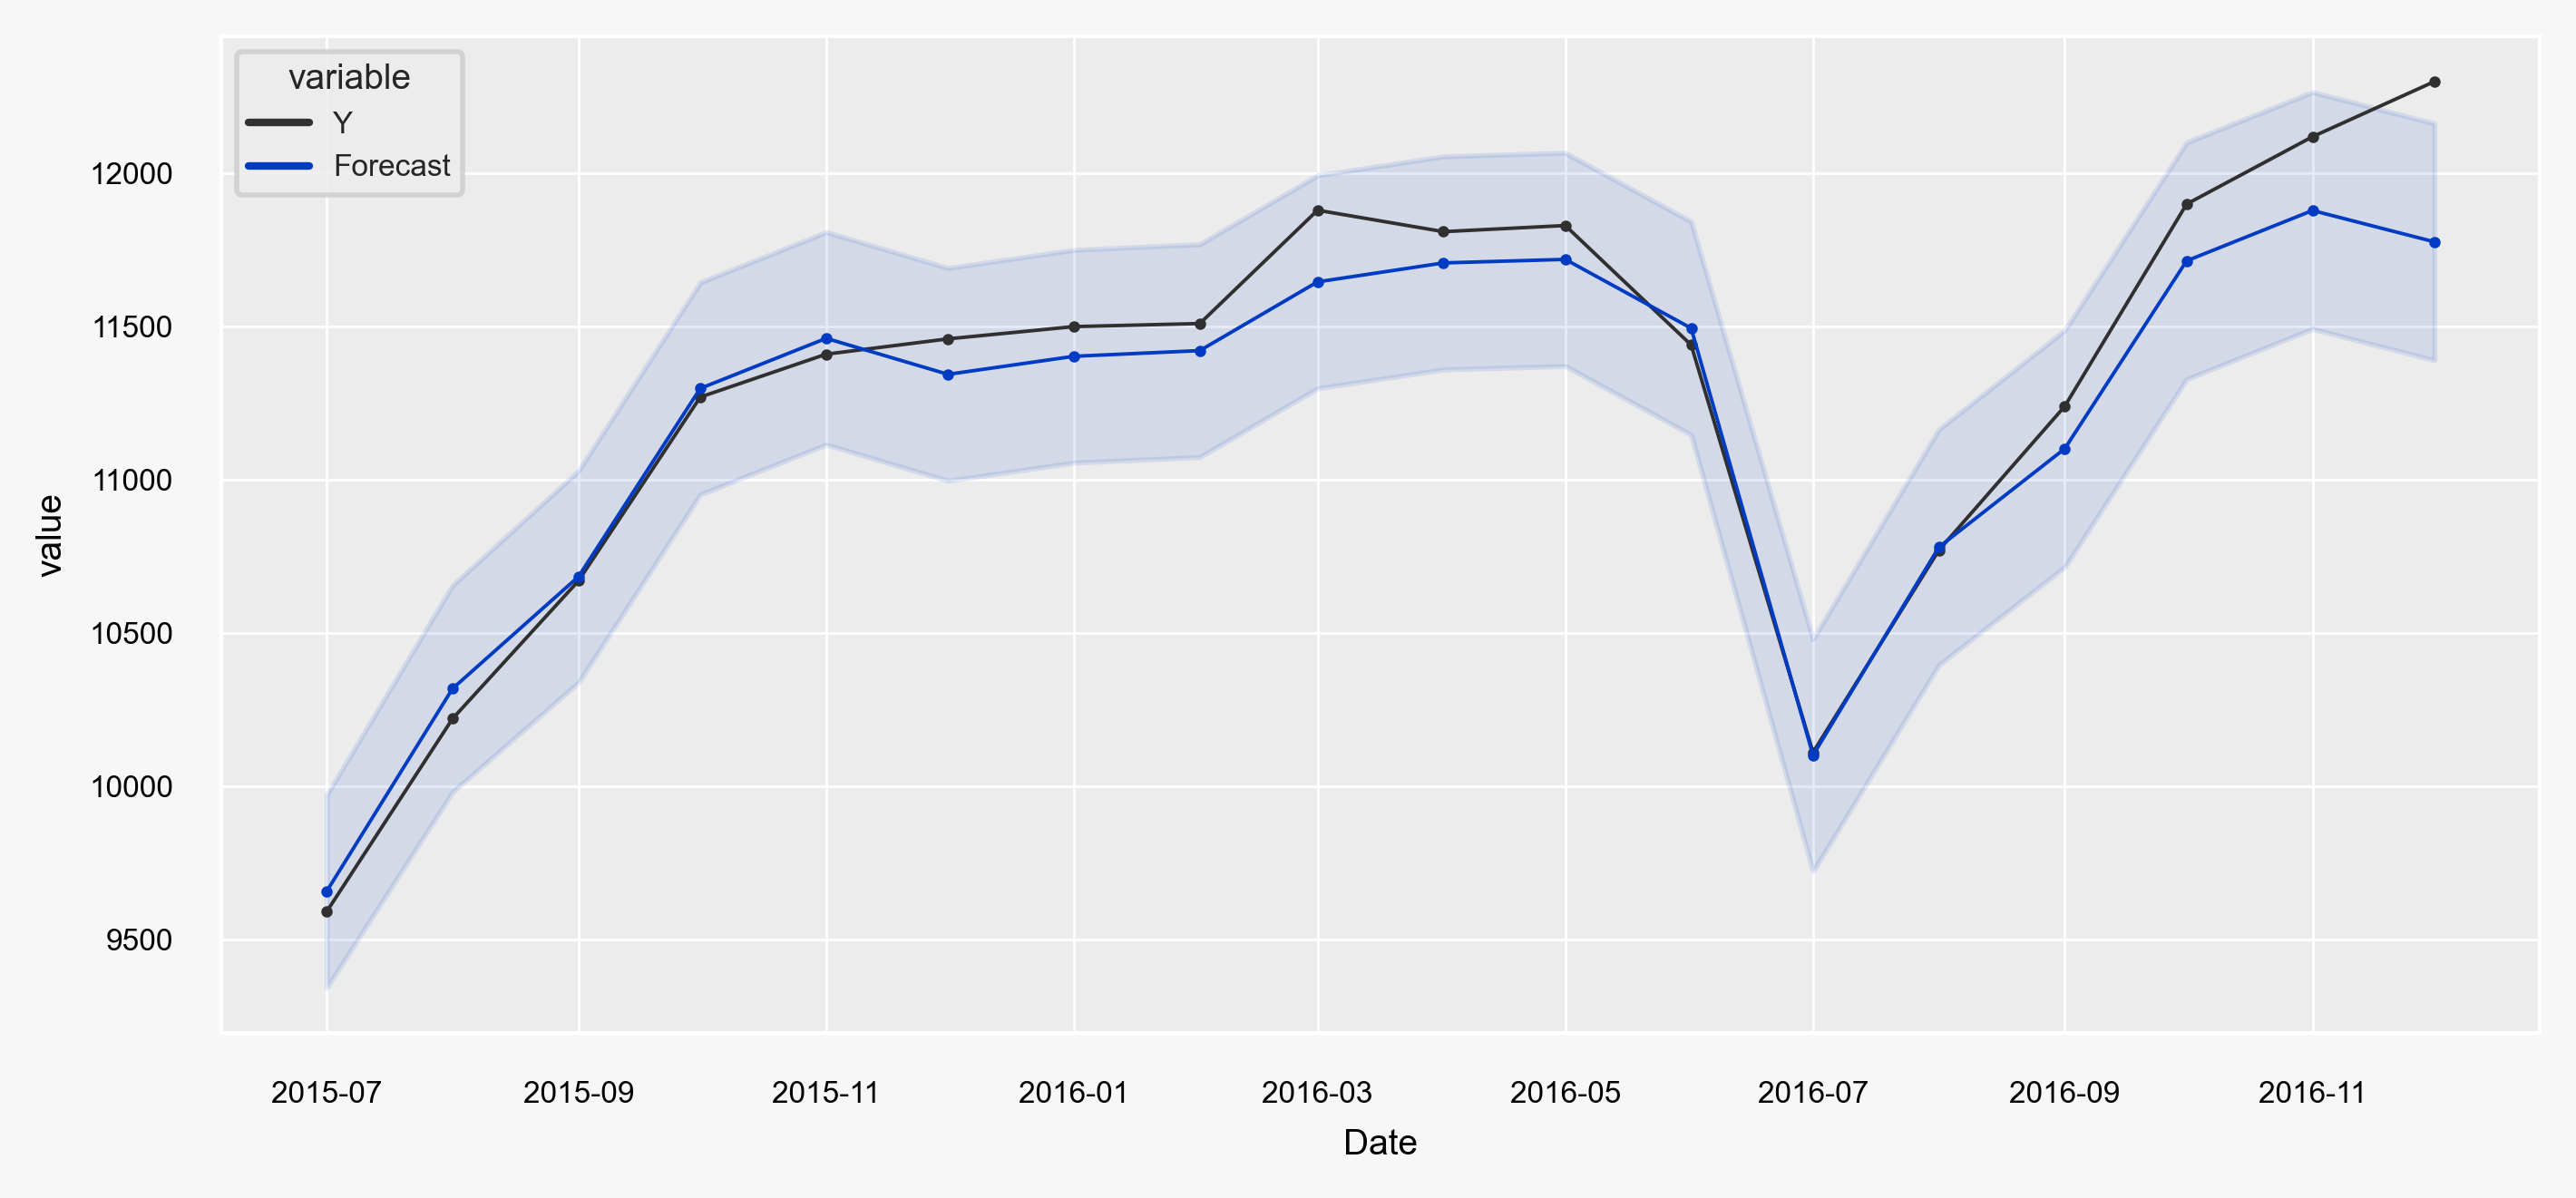

In [71]:
with plt.rc_context(rc={'figure.dpi': 400, 'axes.labelsize': 7, 
                        'xtick.labelsize': 6, 'ytick.labelsize': 6, 
                        'legend.fontsize': 6, 'legend.title_fontsize': 7}):
    
    fig, ax = plt.subplots(2, 1, figsize=(7, 6))
    
    sns.lineplot(ax=ax[0], x=results_1['Date'], y=results_1['value'],
                 hue=results_1['variable'], palette=['#303030', '#003bc4'],
                 markeredgecolor=None, markersize=1.5, lw=0.7, marker='o')

    ax[0].fill_between(x=results_1.loc[results_1['variable'] == 'Forecast', 'Date'], 
                       y1=results_1.loc[results_1['variable'] == 'Forecast', 'L'],
                       y2=results_1.loc[results_1['variable'] == 'Forecast', 'U'], 
                       color='#003bc4', alpha=0.1)
    
    ax[1].set_visible(False)

    plt.tight_layout(pad=0.3)
    plt.show()

<h1><center> IV. Addressing long & multiple seasonality </center></h1>

<p><div style = "text-align: justify; font-size: 14px">It is important to remember that a regression with $ARIMA$ errors can handle 1 source of seasonality with the seasonal period being no greater than 12. Other algorithms such as decision trees, for example, that are not designed to work with time series data don’t have any built-in methods to deal with any seasonality. Thus, we need to introduce additional features to tackle this problem. Creating lots of dummy variables for days, hours, minutes (even months) is not computationally wise. That is when Fourier terms come into play. The following function creates pairs of $sin$ and $cos$ functions necessary to model seasonality:</div></p>

In [72]:
def f_pairs(df, m, opt_m):
    sin_pairs = []
    cos_pairs = []

    for pair in range(opt_m):
        sin_pairs.append([])
        cos_pairs.append([])
    
        for idx in df.index + 1:
            sin_pairs[pair].append(np.sin((2*np.pi * (pair + 1) * idx) / m))
            cos_pairs[pair].append(np.cos((2*np.pi * (pair + 1) * idx) / m))
            
    sin_cos_pairs = sin_pairs + cos_pairs
    sin_cos_pairs = pd.DataFrame(sin_cos_pairs).T
    sin_cos_pairs.columns = ([f'sin_{x}' for x in range(1, opt_m + 1)] + 
                             [f'cos_{x}' for x in range(opt_m + 1, 2*opt_m + 1)])
    
    return sin_cos_pairs

<p><div style = "text-align: justify; font-size: 14px">You need to specify a data frame (<code>df</code>), a seasonal period (<code>m</code>) and the number of pairs you want to create (<code>opt_m</code>). The final parameter (<code>opt_m</code>) should ideally be determined based on the results of a CV loop.</div></p>

<p><div style = "text-align: justify; font-size: 14px"><b>Important note</b>: your test set should have a proper index column, i.e. if the last observation of a train set is 100, the first observation of a test set should be 101, not 0.</div></p>

<p><div style = "text-align: justify; font-size: 14px">Let's see how it works:</div></p>

In [73]:
f_pairs(df=train, m=12, opt_m=2)

sin_1         sin_2         cos_3  cos_4
0    5.000000e-01  8.660254e-01  8.660254e-01    0.5
1    8.660254e-01  8.660254e-01  5.000000e-01   -0.5
2    1.000000e+00  1.224647e-16  6.123234e-17   -1.0
3    8.660254e-01 -8.660254e-01 -5.000000e-01   -0.5
4    5.000000e-01 -8.660254e-01 -8.660254e-01    0.5
..            ...           ...           ...    ...
301  8.660254e-01  8.660254e-01  5.000000e-01   -0.5
302  1.000000e+00  8.816219e-15  4.408109e-15   -1.0
303  8.660254e-01 -8.660254e-01 -5.000000e-01   -0.5
304  5.000000e-01 -8.660254e-01 -8.660254e-01    0.5
305  9.798412e-15 -1.959682e-14 -1.000000e+00    1.0

[306 rows x 4 columns]

<p><div style = "text-align: justify; font-size: 14px">Of course, having both Fourier terms and mean encoded variables means more parameters are needed to be optimised:</div></p>

In [74]:
alpha, n_splits, optimal_m = [1, 2, 3], [5, 7, 10], [3, 4, 5]
opt_params = list(product(alpha, n_splits, optimal_m))
X_f_pairs_mean_enc = []

for a, n_spl, opt_m in opt_params:
    f_p = f_pairs(df=train, m=12, opt_m=opt_m)
    
    m_enc = mean_encode(train=train, test=test, Xs=['Month'], Y='Y', 
                        alpha=a, n_splits=n_spl, test_size=None)
    
    X_f_pairs_mean_enc.append(pd.concat([f_p, m_enc[0], Flags_tr], axis=1))